# Model evaluation on aggregated dataset

Now that an initial model has been tested on the application data, the rest of the tables can be joined to increase model performance.

Importing necessary packages: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import shap
import warnings
from sklearn.exceptions import InconsistentVersionWarning
import joblib
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    recall_score, accuracy_score,
    f1_score, roc_auc_score, average_precision_score, 
    matthews_corrcoef, confusion_matrix, confusion_matrix, 
    classification_report, precision_score)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (HistGradientBoostingClassifier, StackingClassifier, VotingClassifier)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import RFECV
import sys
import os
sys.path.append(os.path.abspath('../functions'))
from functions import get_results, clean_column_names, evaluate_feature_counts, evaluate_feature_subset, format_cm_labels
%matplotlib inline

# Importing data: 

First, each table must be imported.

In [ ]:
train = pd.read_csv('../tables/application_train.csv', sep=',')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
bureau = pd.read_csv('../tables/bureau.csv', sep=',')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
bureau_balance = pd.read_csv('../tables/bureau_balance.csv', sep=',')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
POS_CASH_balance = pd.read_csv('../tables/POS_CASH_balance.csv', sep=',')
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
installments_payments = pd.read_csv('../tables/installments_payments.csv', sep=',')
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [2]:
credit_card_balance = pd.read_csv('../tables/credit_card_balance.csv', sep=',')
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
previous_application = pd.read_csv('../tables/previous_application.csv', sep=',')
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


# Essential preprocessing: 

Next, essential preprocessing seen in EDA is performed.

In [9]:
train.replace('XNA', np.nan, inplace=True)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace(365243, np.nan)
train.loc[(train['OWN_CAR_AGE'].isnull()) & (train['FLAG_OWN_CAR'] == 'N'), 'OWN_CAR_AGE'] = 0
upper_limit = train['AMT_INCOME_TOTAL'].quantile(0.99)
train['AMT_INCOME_TOTAL'] = train['AMT_INCOME_TOTAL'].clip(upper=upper_limit)
days_cols = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION']
for col in days_cols: 
    previous_application[col] = previous_application[col].replace(365243, np.nan)
    


# Train Preprocessing steps together: 

Now, the training data is processed in the same way as optimally found in the app_model notebook: 

In [10]:
train_processed = train.copy()

Grouping high cardinality columns: 

In [11]:
group_map = {
    'Accountants': 'Accountants',
    'Cleaning staff': 'Service',
    'Cooking staff': 'Service',
    'Core staff': 'Core staff',
    'Drivers': 'Drivers', 
    'HR staff': 'Other',
    'High skill tech staff': 'Tech',
    'IT staff': 'Tech',
    'Laborers': 'Laborers', 
    'Low-skil Laborers': 'Laborers',
    'Managers': 'Managers',
    'Medicine staff': 'Medicine',
    'Private service staff': 'Other',
    'Realty agents': 'Other',
    'Sales staff': 'Sales',
    'Secretaries': 'Other',
    'Security staff': 'Other', 
    'Waiters/barmen staff': 'Service'
}
    
train_processed['OCCUPATION_TYPE_GROUPED'] = train_processed['OCCUPATION_TYPE'].map(group_map)

In [12]:
group_map = {
    'Businessman': 'Other',
    'Commercial associate': 'Commercial associate',
    'Pensioner': 'Pensioner',
    'State servant': 'State servant',
    'Student': 'Other', 
    'Unemployed': 'Other',
    'Working': 'Working',
}
    
train_processed['NAME_INCOME_TYPE_GROUPED'] = train_processed['NAME_INCOME_TYPE'].map(group_map)

In [13]:
group_map = {
    'Business Entity Type 3': 'Business',
    'Business Entity Type 2': 'Business',
    'Business Entity Type 1 ': 'Business',
    'XNA': 'Unknown', 
    'Self-employed': 'Self-employed',         
    'Other': 'Other',                  
    'Medicine': 'Public Sector',                
    'Government': 'Public Sector',                
    'School': 'Public Sector',  
    'Kindergarten': 'Public Sector',
    'Security Ministries': 'Public Sector',                  
    'Housing': 'Public Sector',
    'Military': 'Public Sector',
    'Police': 'Public Sector',
    'Postal': 'Public Sector',
    'Security Ministries': 'Public Sector',
    'University': 'Public Sector',
    'Emergency': 'Public Sector',
    'Trade: type 7': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 5': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 2': 'Trade', 
    'Trade: type 1': 'Trade', 
    'Electricity ': 'Trade',        
    'Construction': 'Trade',              
    'Transport: type 4': 'Transport',
    'Transport: type 3': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 1': 'Transport',
    'Industry: type 13': 'Industry',
    'Industry: type 12 ': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 8': 'Industry',
    'Industry: type 7': 'Industry', 
    'Industry: type 6': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 4 ': 'Industry',       
    'Industry: type 3': 'Industry', 
    'Industry: type 2 ': 'Industry',
    'Industry: type 1 ': 'Industry',      
    'Industry: type 11': 'Industry', 
    'Agriculture': 'Industry',
    'Services ': 'Service',  
    'Hotel': 'Service',
    'Restaurant': 'Service',
    'Cleaning': 'Service',
    'Realtor': 'Service',
    'Legal Services': 'Service',
    'Advertising': 'Other',   
    'Religion': 'Other',
    'Culture': 'Other',
    'Bank': 'Finance',
    'Insurance': 'Finance',
    'Telecom': 'Other',
    'Mobile': 'Other'
}
    
train_processed['ORGANIZATION_TYPE_GROUPED'] = train_processed['ORGANIZATION_TYPE'].map(group_map)

In [14]:
group_map = {
    'House / apartment': 'House / apartment',
    'Municipal apartment': 'Other apartment',
    'Office apartment': 'Other apartment',
    'Rented apartment': 'Other apartment',
    'With parents': 'With parents',
    'Co-op apartment': 'Other apartment',
}
    
train_processed['NAME_HOUSING_TYPE_GROUPED'] = train_processed['NAME_HOUSING_TYPE'].map(group_map)

In [15]:
train_processed = train_processed.drop(columns=['OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'ORGANIZATION_TYPE', 'NAME_HOUSING_TYPE'])

Making sure that categorical columns are of type 'category': 

In [16]:
cat_features = train_processed.select_dtypes(include='object').columns.tolist()
cat_features_index = [train_processed.columns.get_loc(col) for col in cat_features]
for col in cat_features: 
    train_processed[col] = train_processed[col].fillna('missing') 
    train_processed[col] = train_processed[col].astype('category')

Adding beneficial features: 

In [17]:
train_processed['credit_annuity_ratio'] = (train_processed['AMT_CREDIT'] / train_processed['AMT_ANNUITY'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
train_processed['age_score_ratio'] = (train_processed['DAYS_BIRTH'] / train_processed['EXT_SOURCE_1'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
train_processed['score_credit_ratio'] = (train_processed['EXT_SOURCE_2'] / train_processed['AMT_CREDIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
train_processed['income_goods_ratio'] = (train_processed['AMT_INCOME_TOTAL'] / train_processed['AMT_GOODS_PRICE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
train_processed['SUM_FLAG_DOCUMENT'] = train_processed['FLAG_DOCUMENT_2'] + train_processed['FLAG_DOCUMENT_3'] + train_processed['FLAG_DOCUMENT_4'] + train_processed['FLAG_DOCUMENT_5'] + train_processed['FLAG_DOCUMENT_6'] + train_processed['FLAG_DOCUMENT_7'] + train_processed['FLAG_DOCUMENT_8'] + train_processed['FLAG_DOCUMENT_9'] + train_processed['FLAG_DOCUMENT_10'] + train_processed['FLAG_DOCUMENT_11'] + train_processed['FLAG_DOCUMENT_12'] + train_processed['FLAG_DOCUMENT_13'] + train_processed['FLAG_DOCUMENT_14'] + train_processed['FLAG_DOCUMENT_15'] + train_processed['FLAG_DOCUMENT_16'] + train_processed['FLAG_DOCUMENT_17'] + train_processed['FLAG_DOCUMENT_18'] + train_processed['FLAG_DOCUMENT_19'] + train_processed['FLAG_DOCUMENT_20'] + train_processed['FLAG_DOCUMENT_21']

Encoding categorical variables: 

In [18]:
cat_features = train_processed.select_dtypes(include=['object', 'category']).columns.tolist()
cat_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'WEEKDAY_APPR_PROCESS_START',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE_GROUPED',
 'NAME_INCOME_TYPE_GROUPED',
 'ORGANIZATION_TYPE_GROUPED',
 'NAME_HOUSING_TYPE_GROUPED']

In [19]:
train_processed_encoded = pd.get_dummies(train_processed, columns=cat_features, drop_first=False)
train_processed_encoded.columns = train_processed_encoded.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

In [20]:
dupe_columns = train_processed_encoded.columns[train_processed_encoded.columns.duplicated()]
train_processed_encoded = train_processed_encoded.loc[:, ~train_processed_encoded.columns.duplicated()]


Making sure that any boolean columns are of type integer: 

In [21]:
bool_cols = train_processed_encoded.select_dtypes(include='bool').columns
train_processed_encoded[bool_cols] = train_processed_encoded[bool_cols].astype(int)

# Feature Engineering 

As feature engineering has already been performed with the application table, this can now be done with other tables. One by one, a new feature is added, and a model is tested with this new feature. Here are features that improve model auc: 

In [22]:
installments_payments['late_payment_lag'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
credit_card_balance['max_drawings_receivable_ratio'] = (credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'] / credit_card_balance['AMT_TOTAL_RECEIVABLE'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
bureau['credit_usage'] = (bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
POS_CASH_balance['credit_term_ratio'] = (POS_CASH_balance['CNT_INSTALMENT_FUTURE'] / POS_CASH_balance['CNT_INSTALMENT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
bureau['bureau_debt_over_limit'] = (bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM_LIMIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
previous_application['first_dibursement_ratio'] = (previous_application['DAYS_FIRST_DRAWING'] / previous_application['DAYS_FIRST_DUE']).replace(0, np.nan).replace([np.inf, -np.inf], np.nan).fillna(0)

Features that were not an improvement: 


In [23]:
#installments_payments['overpay_ratio'] = (installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#installments_payments['paid_late'] = installments_payments['AMT_PAYMENT'] - installments_payments['AMT_INSTALMENT']
#previous_application['app_credit_diff'] = previous_application['AMT_APPLICATION'] - previous_application['AMT_CREDIT']
#previous_application['ratio_credit_annuity'] = (previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#previous_application['down_payment_annuity_ratio'] = (previous_application['AMT_DOWN_PAYMENT'] / previous_application['AMT_ANNUITY'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#credit_card_balance['tot_amt_draw'] = credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] - credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'] + credit_card_balance['AMT_DRAWINGS_CURRENT'] + credit_card_balance['AMT_DRAWINGS_OTHER_CURRENT'] + credit_card_balance['AMT_DRAWINGS_POS_CURRENT']
#credit_card_balance['tot_cnt_draw'] = credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] - credit_card_balance['CNT_DRAWINGS_ATM_CURRENT'] + credit_card_balance['CNT_DRAWINGS_CURRENT'] + credit_card_balance['CNT_DRAWINGS_OTHER_CURRENT'] + credit_card_balance['CNT_DRAWINGS_POS_CURRENT']
#credit_card_balance['amt_sub'] = credit_card_balance['AMT_INST_MIN_REGULARITY'] - credit_card_balance['AMT_PAYMENT_CURRENT']
#credit_card_balance['amt_balance_sub_limit'] = credit_card_balance['AMT_BALANCE'] - credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']
#previous_application['requested_vs_amount'] = (previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#previous_application['first_dibursement_diff'] = previous_application['DAYS_FIRST_DUE'] - previous_application['DAYS_LAST_DUE_1ST_VERSION']
#bureau['active_flag'] = (bureau['CREDIT_ACTIVE'] == 'Active').astype(int)
#bureau['bureau_credit_duration'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
#installments_payments['late_flag'] = (installments_payments['DAYS_ENTRY_PAYMENT'] > installments_payments['DAYS_INSTALMENT']).astype(int)
#credit_card_balance['drawdown_ratio'] = (credit_card_balance['AMT_BALANCE'] / credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
#credit_card_balance['missed_payment'] = (credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] < credit_card_balance['AMT_INST_MIN_REGULARITY']).astype(int)
#POS_CASH_balance['completed'] = (POS_CASH_balance['NAME_CONTRACT_STATUS'] == 'Completed').astype(int)
#POS_CASH_balance['max_dpd'] = POS_CASH_balance['SK_DPD'].groupby(POS_CASH_balance['SK_ID_CURR']).transform('max')
#previous_application['is_approved'] = (previous_application['NAME_CONTRACT_STATUS'] == 'Approved').astype(int)
#previous_application['app_to_current_gap'] = previous_application['DAYS_DECISION'] - previous_application['DAYS_FIRST_DRAWING']
#previous_application['amt_ratio'] = (previous_application['AMT_CREDIT'] / previous_application['AMT_APPLICATION'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)

# Merging tables: 

Now, tables can be aggregated and merged together. First, child tables need to be merged to their parent tables before merging to the main application table. Starting with the aggregation of bureau_balance, a copy of the dataframes are made:

## Bureau_balance to bureau

In [24]:
bb = bureau_balance.copy()
bur = bureau.copy()

Next, object type columns are selected and aggregated: 

In [25]:
bureau_cat_cols = bb.select_dtypes(include=['object']).columns.tolist()
bureau_cat_cols

['STATUS']

The categorical columns are one hot encoded and aggregated

In [26]:
bureau_cat_dummies = pd.get_dummies(bb[bureau_cat_cols], prefix=bureau_cat_cols)
bureau_cat_encoded = pd.concat([bb[['SK_ID_BUREAU']], bureau_cat_dummies], axis=1)
bureau_cat_counts = bureau_cat_encoded.groupby('SK_ID_BUREAU').sum()
bureau_cat_counts.columns = ['bureau_CNT_' + col for col in bureau_cat_counts.columns]
bureau_cat_counts.head()

,bureau_CNT_STATUS_0,bureau_CNT_STATUS_1,bureau_CNT_STATUS_2,bureau_CNT_STATUS_3,bureau_CNT_STATUS_4,bureau_CNT_STATUS_5,bureau_CNT_STATUS_C,bureau_CNT_STATUS_X
SK_ID_BUREAU,,,,,,,,
5001709,0,0,0,0,0,0,86,11
5001710,5,0,0,0,0,0,48,30
5001711,3,0,0,0,0,0,0,1
5001712,10,0,0,0,0,0,9,0
5001713,0,0,0,0,0,0,0,22


Now, numerical columns are selected and aggregated:

In [27]:
bb_num_cols = bb.select_dtypes(exclude=['object']).columns.tolist()
bb_num_cols.remove('SK_ID_BUREAU')
bb_num_cols

['MONTHS_BALANCE']

In [28]:
bb_num_agg = bb.groupby('SK_ID_BUREAU')[bb_num_cols].agg(['mean', 'min', 'max', 'std'])
bb_num_agg.columns = ['bureau_NUM_' + '_'.join(col) for col in bb_num_agg.columns]
bb_num_agg.head()

,bureau_NUM_MONTHS_BALANCE_mean,bureau_NUM_MONTHS_BALANCE_min,bureau_NUM_MONTHS_BALANCE_max,bureau_NUM_MONTHS_BALANCE_std
SK_ID_BUREAU,,,,
5001709,-48.0,-96,0,28.145456
5001710,-41.0,-82,0,24.103942
5001711,-1.5,-3,0,1.290994
5001712,-9.0,-18,0,5.627314
5001713,-10.5,-21,0,6.493587


Now, the numerical and categorical columns are merged: 

In [29]:
bb_agg = pd.merge(bb_num_agg, bureau_cat_counts, on='SK_ID_BUREAU', how='outer')
bb_agg.head()

,bureau_NUM_MONTHS_BALANCE_mean,bureau_NUM_MONTHS_BALANCE_min,bureau_NUM_MONTHS_BALANCE_max,bureau_NUM_MONTHS_BALANCE_std,bureau_CNT_STATUS_0,bureau_CNT_STATUS_1,bureau_CNT_STATUS_2,bureau_CNT_STATUS_3,bureau_CNT_STATUS_4,bureau_CNT_STATUS_5,bureau_CNT_STATUS_C,bureau_CNT_STATUS_X
SK_ID_BUREAU,,,,,,,,,,,,
5001709,-48.0,-96,0,28.145456,0,0,0,0,0,0,86,11
5001710,-41.0,-82,0,24.103942,5,0,0,0,0,0,48,30
5001711,-1.5,-3,0,1.290994,3,0,0,0,0,0,0,1
5001712,-9.0,-18,0,5.627314,10,0,0,0,0,0,9,0
5001713,-10.5,-21,0,6.493587,0,0,0,0,0,0,0,22


This is merged to the bureau table: 

In [30]:
bur = bur.merge(bb_agg, on='SK_ID_BUREAU', how='left')
bur.head()


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,bureau_NUM_MONTHS_BALANCE_max,bureau_NUM_MONTHS_BALANCE_std,bureau_CNT_STATUS_0,bureau_CNT_STATUS_1,bureau_CNT_STATUS_2,bureau_CNT_STATUS_3,bureau_CNT_STATUS_4,bureau_CNT_STATUS_5,bureau_CNT_STATUS_C,bureau_CNT_STATUS_X
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Bureau to train

Column types are selected for the bureau table: 

In [31]:
bur_cat_cols = bur.select_dtypes(include=['object']).columns.tolist()

bur_binary_cols = [col for col in bur.columns 
               if set(bur[col].dropna().unique()).issubset({0, 1})]

bur_num_cols = bur.select_dtypes(exclude=['object']).columns.tolist()
bur_num_cols.remove('SK_ID_BUREAU')
bur_num_cols.remove('SK_ID_CURR')
for col in bur_num_cols:
    if col in bur_binary_cols:
        bur_num_cols.remove(col)

Categorical columns are aggregated: 

In [32]:
agg_bur_cat_dummies = pd.get_dummies(bur[bur_cat_cols], prefix=bur_cat_cols)
agg_bureau_cat_encoded = pd.concat([bur[['SK_ID_BUREAU']], agg_bur_cat_dummies], axis=1)

agg_bureau_cat_counts = agg_bureau_cat_encoded.groupby('SK_ID_BUREAU').sum()
agg_bureau_cat_counts.columns = ['bureau_CNT_' + col for col in agg_bureau_cat_counts.columns]
agg_bureau_cat_counts.reset_index(inplace=True)
agg_bureau_cat_counts.head()

,SK_ID_BUREAU,bureau_CNT_CREDIT_ACTIVE_Active,bureau_CNT_CREDIT_ACTIVE_Bad debt,bureau_CNT_CREDIT_ACTIVE_Closed,bureau_CNT_CREDIT_ACTIVE_Sold,bureau_CNT_CREDIT_CURRENCY_currency 1,bureau_CNT_CREDIT_CURRENCY_currency 2,bureau_CNT_CREDIT_CURRENCY_currency 3,bureau_CNT_CREDIT_CURRENCY_currency 4,bureau_CNT_CREDIT_TYPE_Another type of loan,...,bureau_CNT_CREDIT_TYPE_Interbank credit,bureau_CNT_CREDIT_TYPE_Loan for business development,bureau_CNT_CREDIT_TYPE_Loan for purchase of shares (margin lending),bureau_CNT_CREDIT_TYPE_Loan for the purchase of equipment,bureau_CNT_CREDIT_TYPE_Loan for working capital replenishment,bureau_CNT_CREDIT_TYPE_Microloan,bureau_CNT_CREDIT_TYPE_Mobile operator loan,bureau_CNT_CREDIT_TYPE_Mortgage,bureau_CNT_CREDIT_TYPE_Real estate loan,bureau_CNT_CREDIT_TYPE_Unknown type of loan
0,5000000,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5000001,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5000002,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5000003,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5000004,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Numerical columns are aggregated: 

In [33]:
bureau_num_agg = bur.groupby('SK_ID_BUREAU')[bur_num_cols].agg(['mean', 'min', 'max', 'std'])
bureau_num_agg.columns = ['bureau_NUM_' + '_'.join(col) for col in bureau_num_agg.columns]
bureau_num_agg.reset_index(inplace=True)
bureau_num_agg.head()

,SK_ID_BUREAU,bureau_NUM_DAYS_CREDIT_mean,bureau_NUM_DAYS_CREDIT_min,bureau_NUM_DAYS_CREDIT_max,bureau_NUM_DAYS_CREDIT_std,bureau_NUM_CREDIT_DAY_OVERDUE_mean,bureau_NUM_CREDIT_DAY_OVERDUE_min,bureau_NUM_CREDIT_DAY_OVERDUE_max,bureau_NUM_CREDIT_DAY_OVERDUE_std,bureau_NUM_DAYS_CREDIT_ENDDATE_mean,...,bureau_NUM_bureau_CNT_STATUS_5_max,bureau_NUM_bureau_CNT_STATUS_5_std,bureau_NUM_bureau_CNT_STATUS_C_mean,bureau_NUM_bureau_CNT_STATUS_C_min,bureau_NUM_bureau_CNT_STATUS_C_max,bureau_NUM_bureau_CNT_STATUS_C_std,bureau_NUM_bureau_CNT_STATUS_X_mean,bureau_NUM_bureau_CNT_STATUS_X_min,bureau_NUM_bureau_CNT_STATUS_X_max,bureau_NUM_bureau_CNT_STATUS_X_std
0,5000000,-2918.0,-2918,-2918,NaN,0.0,0,0,NaN,-2613.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5000001,-1015.0,-1015,-1015,NaN,0.0,0,0,NaN,-831.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5000002,-149.0,-149,-149,NaN,0.0,0,0,NaN,-26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5000003,-135.0,-135,-135,NaN,0.0,0,0,NaN,230.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5000004,-47.0,-47,-47,NaN,0.0,0,0,NaN,320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The numerical and categorical columns are merged together: 

In [34]:
bur_merged = bureau_num_agg.merge(agg_bureau_cat_counts, on='SK_ID_BUREAU', how='outer')
bur_merged.columns = [col.replace(' ', '_') for col in bur_merged.columns]
bur_merged.head()

,SK_ID_BUREAU,bureau_NUM_DAYS_CREDIT_mean,bureau_NUM_DAYS_CREDIT_min,bureau_NUM_DAYS_CREDIT_max,bureau_NUM_DAYS_CREDIT_std,bureau_NUM_CREDIT_DAY_OVERDUE_mean,bureau_NUM_CREDIT_DAY_OVERDUE_min,bureau_NUM_CREDIT_DAY_OVERDUE_max,bureau_NUM_CREDIT_DAY_OVERDUE_std,bureau_NUM_DAYS_CREDIT_ENDDATE_mean,...,bureau_CNT_CREDIT_TYPE_Interbank_credit,bureau_CNT_CREDIT_TYPE_Loan_for_business_development,bureau_CNT_CREDIT_TYPE_Loan_for_purchase_of_shares_(margin_lending),bureau_CNT_CREDIT_TYPE_Loan_for_the_purchase_of_equipment,bureau_CNT_CREDIT_TYPE_Loan_for_working_capital_replenishment,bureau_CNT_CREDIT_TYPE_Microloan,bureau_CNT_CREDIT_TYPE_Mobile_operator_loan,bureau_CNT_CREDIT_TYPE_Mortgage,bureau_CNT_CREDIT_TYPE_Real_estate_loan,bureau_CNT_CREDIT_TYPE_Unknown_type_of_loan
0,5000000,-2918.0,-2918,-2918,NaN,0.0,0,0,NaN,-2613.0,...,0,0,0,0,0,0,0,0,0,0
1,5000001,-1015.0,-1015,-1015,NaN,0.0,0,0,NaN,-831.0,...,0,0,0,0,0,0,0,0,0,0
2,5000002,-149.0,-149,-149,NaN,0.0,0,0,NaN,-26.0,...,0,0,0,0,0,0,0,0,0,0
3,5000003,-135.0,-135,-135,NaN,0.0,0,0,NaN,230.0,...,0,0,0,0,0,0,0,0,0,0
4,5000004,-47.0,-47,-47,NaN,0.0,0,0,NaN,320.0,...,0,0,0,0,0,0,0,0,0,0


The bureau id column is dropped: 

In [35]:
bureau_id_map = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].drop_duplicates()
bureau_merged = bur_merged.merge(bureau_id_map, on='SK_ID_BUREAU', how='left')
bureau_agg = bureau_merged.drop(columns=['SK_ID_BUREAU'])
bureau_agg = bureau_agg.copy()
bureau_agg.head()

,bureau_NUM_DAYS_CREDIT_mean,bureau_NUM_DAYS_CREDIT_min,bureau_NUM_DAYS_CREDIT_max,bureau_NUM_DAYS_CREDIT_std,bureau_NUM_CREDIT_DAY_OVERDUE_mean,bureau_NUM_CREDIT_DAY_OVERDUE_min,bureau_NUM_CREDIT_DAY_OVERDUE_max,bureau_NUM_CREDIT_DAY_OVERDUE_std,bureau_NUM_DAYS_CREDIT_ENDDATE_mean,bureau_NUM_DAYS_CREDIT_ENDDATE_min,...,bureau_CNT_CREDIT_TYPE_Loan_for_business_development,bureau_CNT_CREDIT_TYPE_Loan_for_purchase_of_shares_(margin_lending),bureau_CNT_CREDIT_TYPE_Loan_for_the_purchase_of_equipment,bureau_CNT_CREDIT_TYPE_Loan_for_working_capital_replenishment,bureau_CNT_CREDIT_TYPE_Microloan,bureau_CNT_CREDIT_TYPE_Mobile_operator_loan,bureau_CNT_CREDIT_TYPE_Mortgage,bureau_CNT_CREDIT_TYPE_Real_estate_loan,bureau_CNT_CREDIT_TYPE_Unknown_type_of_loan,SK_ID_CURR
0,-2918.0,-2918,-2918,NaN,0.0,0,0,NaN,-2613.0,-2613.0,...,0,0,0,0,0,0,0,0,0,166497
1,-1015.0,-1015,-1015,NaN,0.0,0,0,NaN,-831.0,-831.0,...,0,0,0,0,0,0,0,0,0,166497
2,-149.0,-149,-149,NaN,0.0,0,0,NaN,-26.0,-26.0,...,0,0,0,0,0,0,0,0,0,166497
3,-135.0,-135,-135,NaN,0.0,0,0,NaN,230.0,230.0,...,0,0,0,0,0,0,0,0,0,166497
4,-47.0,-47,-47,NaN,0.0,0,0,NaN,320.0,320.0,...,0,0,0,0,0,0,0,0,0,166497


The new bureau columns are aggregated by SK_ID_CURR to join them to the application table: 

In [36]:
bureau_final = bureau_agg.groupby('SK_ID_CURR').agg(['mean'])
bureau_final.columns = ['BUREAU_' + '_'.join(col) for col in bureau_final.columns]
bureau_final.reset_index(inplace=True)
bureau_final.head()

/var/folders/vv/xzwg5pcx00j9l1dcsnsxf7mr0000gn/T/ipykernel_1040/2923766509.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bureau_final.reset_index(inplace=True)


,SK_ID_CURR,BUREAU_bureau_NUM_DAYS_CREDIT_mean_mean,BUREAU_bureau_NUM_DAYS_CREDIT_min_mean,BUREAU_bureau_NUM_DAYS_CREDIT_max_mean,BUREAU_bureau_NUM_DAYS_CREDIT_std_mean,BUREAU_bureau_NUM_CREDIT_DAY_OVERDUE_mean_mean,BUREAU_bureau_NUM_CREDIT_DAY_OVERDUE_min_mean,BUREAU_bureau_NUM_CREDIT_DAY_OVERDUE_max_mean,BUREAU_bureau_NUM_CREDIT_DAY_OVERDUE_std_mean,BUREAU_bureau_NUM_DAYS_CREDIT_ENDDATE_mean_mean,...,BUREAU_bureau_CNT_CREDIT_TYPE_Interbank_credit_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Loan_for_business_development_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Loan_for_purchase_of_shares_(margin_lending)_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Loan_for_working_capital_replenishment_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Microloan_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Mobile_operator_loan_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Mortgage_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Real_estate_loan_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Unknown_type_of_loan_mean
0,100001,-735.000000,-735.000000,-735.000000,NaN,0.0,0.0,0.0,NaN,82.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,-874.000000,-874.000000,-874.000000,NaN,0.0,0.0,0.0,NaN,-349.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,-1400.750000,-1400.750000,-1400.750000,NaN,0.0,0.0,0.0,NaN,-544.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,-867.000000,-867.000000,-867.000000,NaN,0.0,0.0,0.0,NaN,-488.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,-190.666667,-190.666667,-190.666667,NaN,0.0,0.0,0.0,NaN,439.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The aggregated bureau table is joined to the application table: 

In [37]:
bureau_final = bureau_final.copy()
app_train = train_processed_encoded.merge(bureau_final, on='SK_ID_CURR', how='left')
app_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,BUREAU_bureau_CNT_CREDIT_TYPE_Interbank_credit_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Loan_for_business_development_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Loan_for_purchase_of_shares_(margin_lending)_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Loan_for_working_capital_replenishment_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Microloan_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Mobile_operator_loan_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Mortgage_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Real_estate_loan_mean,BUREAU_bureau_CNT_CREDIT_TYPE_Unknown_type_of_loan_mean
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## POS_cash_balance to previous_application

The POS_cash_balance table is joined to the previous_application table: 

In [38]:
pos = POS_CASH_balance.copy()

Categorical columns are selected: 

In [39]:
cat_cols = pos.select_dtypes(include=['object']).columns.tolist()
cat_cols

['NAME_CONTRACT_STATUS']

Categorical columns are aggregated: 

In [40]:
cat_dummies = pd.get_dummies(pos[cat_cols], prefix=cat_cols)
cat_encoded = pd.concat([pos[['SK_ID_PREV']], cat_dummies], axis=1)
cat_counts = cat_encoded.groupby('SK_ID_PREV').sum()
cat_counts.columns = ['POS_CNT_' + col for col in cat_counts.columns]
cat_counts.head()

,POS_CNT_NAME_CONTRACT_STATUS_Active,POS_CNT_NAME_CONTRACT_STATUS_Amortized debt,POS_CNT_NAME_CONTRACT_STATUS_Approved,POS_CNT_NAME_CONTRACT_STATUS_Canceled,POS_CNT_NAME_CONTRACT_STATUS_Completed,POS_CNT_NAME_CONTRACT_STATUS_Demand,POS_CNT_NAME_CONTRACT_STATUS_Returned to the store,POS_CNT_NAME_CONTRACT_STATUS_Signed,POS_CNT_NAME_CONTRACT_STATUS_XNA
SK_ID_PREV,,,,,,,,,
1000001,2,0,0,0,1,0,0,0,0
1000002,4,0,0,0,1,0,0,0,0
1000003,4,0,0,0,0,0,0,0,0
1000004,7,0,0,0,1,0,0,0,0
1000005,10,0,0,0,1,0,0,0,0


Are any binary columns present? 

In [41]:
binary_cols = [col for col in pos.columns 
               if set(pos[col].dropna().unique()).issubset({0, 1})]
binary_cols

[]

No binary columns are present.

Selecting numerical columns: 

In [42]:
num_cols = pos.select_dtypes(exclude=['object']).columns.tolist()
num_cols.remove('SK_ID_PREV')
num_cols.remove('SK_ID_CURR')
for col in num_cols:
    if col in binary_cols:
        num_cols.remove(col)
num_cols

['MONTHS_BALANCE',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD',
 'SK_DPD_DEF',
 'credit_term_ratio']

Aggregating numerical columns: 

In [43]:
num_agg = pos.groupby('SK_ID_PREV')[num_cols].agg(['mean', 'min', 'max', 'std'])
num_agg.columns = ['POS_NUM_' + '_'.join(col) for col in num_agg.columns]
num_agg.reset_index(inplace=True)
num_agg.head()

,SK_ID_PREV,POS_NUM_MONTHS_BALANCE_mean,POS_NUM_MONTHS_BALANCE_min,POS_NUM_MONTHS_BALANCE_max,POS_NUM_MONTHS_BALANCE_std,POS_NUM_CNT_INSTALMENT_mean,POS_NUM_CNT_INSTALMENT_min,POS_NUM_CNT_INSTALMENT_max,POS_NUM_CNT_INSTALMENT_std,POS_NUM_CNT_INSTALMENT_FUTURE_mean,...,POS_NUM_SK_DPD_max,POS_NUM_SK_DPD_std,POS_NUM_SK_DPD_DEF_mean,POS_NUM_SK_DPD_DEF_min,POS_NUM_SK_DPD_DEF_max,POS_NUM_SK_DPD_DEF_std,POS_NUM_credit_term_ratio_mean,POS_NUM_credit_term_ratio_min,POS_NUM_credit_term_ratio_max,POS_NUM_credit_term_ratio_std
0,1000001,-9.0,-10,-8,1.000000,8.666667,2.0,12.0,5.773503,7.666667,...,0,0.0,0.0,0,0,0.0,0.638889,0.00,1.0,0.554861
1,1000002,-52.0,-54,-50,1.581139,5.200000,4.0,6.0,1.095445,2.000000,...,0,0.0,0.0,0,0,0.0,0.400000,0.00,1.0,0.383695
2,1000003,-2.5,-4,-1,1.290994,12.000000,12.0,12.0,0.000000,10.500000,...,0,0.0,0.0,0,0,0.0,0.875000,0.75,1.0,0.107583
3,1000004,-25.5,-29,-22,2.449490,9.625000,7.0,10.0,1.060660,6.125000,...,0,0.0,0.0,0,0,0.0,0.612500,0.00,1.0,0.318198
4,1000005,-51.0,-56,-46,3.316625,10.000000,10.0,10.0,0.000000,5.000000,...,0,0.0,0.0,0,0,0.0,0.500000,0.00,1.0,0.331662


Merging the numerical and categorical columns together: 

In [44]:
agg_pos = num_agg.merge(cat_counts, on='SK_ID_PREV', how='outer')
agg_pos.head()

,SK_ID_PREV,POS_NUM_MONTHS_BALANCE_mean,POS_NUM_MONTHS_BALANCE_min,POS_NUM_MONTHS_BALANCE_max,POS_NUM_MONTHS_BALANCE_std,POS_NUM_CNT_INSTALMENT_mean,POS_NUM_CNT_INSTALMENT_min,POS_NUM_CNT_INSTALMENT_max,POS_NUM_CNT_INSTALMENT_std,POS_NUM_CNT_INSTALMENT_FUTURE_mean,...,POS_NUM_credit_term_ratio_std,POS_CNT_NAME_CONTRACT_STATUS_Active,POS_CNT_NAME_CONTRACT_STATUS_Amortized debt,POS_CNT_NAME_CONTRACT_STATUS_Approved,POS_CNT_NAME_CONTRACT_STATUS_Canceled,POS_CNT_NAME_CONTRACT_STATUS_Completed,POS_CNT_NAME_CONTRACT_STATUS_Demand,POS_CNT_NAME_CONTRACT_STATUS_Returned to the store,POS_CNT_NAME_CONTRACT_STATUS_Signed,POS_CNT_NAME_CONTRACT_STATUS_XNA
0,1000001,-9.0,-10,-8,1.000000,8.666667,2.0,12.0,5.773503,7.666667,...,0.554861,2,0,0,0,1,0,0,0,0
1,1000002,-52.0,-54,-50,1.581139,5.200000,4.0,6.0,1.095445,2.000000,...,0.383695,4,0,0,0,1,0,0,0,0
2,1000003,-2.5,-4,-1,1.290994,12.000000,12.0,12.0,0.000000,10.500000,...,0.107583,4,0,0,0,0,0,0,0,0
3,1000004,-25.5,-29,-22,2.449490,9.625000,7.0,10.0,1.060660,6.125000,...,0.318198,7,0,0,0,1,0,0,0,0
4,1000005,-51.0,-56,-46,3.316625,10.000000,10.0,10.0,0.000000,5.000000,...,0.331662,10,0,0,0,1,0,0,0,0


Merging the aggregated POS_cash_balance table to the previous_application table: 

In [45]:
previous = previous_application.copy()
previous = previous.merge(agg_pos, on='SK_ID_PREV', how='left')
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,POS_NUM_credit_term_ratio_std,POS_CNT_NAME_CONTRACT_STATUS_Active,POS_CNT_NAME_CONTRACT_STATUS_Amortized debt,POS_CNT_NAME_CONTRACT_STATUS_Approved,POS_CNT_NAME_CONTRACT_STATUS_Canceled,POS_CNT_NAME_CONTRACT_STATUS_Completed,POS_CNT_NAME_CONTRACT_STATUS_Demand,POS_CNT_NAME_CONTRACT_STATUS_Returned to the store,POS_CNT_NAME_CONTRACT_STATUS_Signed,POS_CNT_NAME_CONTRACT_STATUS_XNA
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,0.707107,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,0.043921,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,0.252304,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,0.312731,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Installments_payments to previous_application

The installments_payments table is merged to the previous_application table in the same way: 

In [46]:
ip = installments_payments.copy()

Column types are selected: 

In [47]:
ip_cat_cols = ip.select_dtypes(include=['object']).columns.tolist()

ip_binary_cols = [col for col in ip.columns 
               if set(ip[col].dropna().unique()).issubset({0, 1})]

ip_num_cols = ip.select_dtypes(exclude=['object']).columns.tolist()
if 'SK_ID_PREV' in ip_num_cols:
    ip_num_cols.remove('SK_ID_PREV')
if 'SK_ID_CURR' in ip_num_cols:
    ip_num_cols.remove('SK_ID_CURR')
for col in ip_num_cols:
    if col in ip_binary_cols:
        ip_num_cols.remove(col)

Only numerical columns are present in this table, and these are aggregated: 

In [48]:
ip_agg = ip.groupby('SK_ID_PREV')[ip_num_cols].agg(['mean', 'min', 'max', 'std'])
ip_agg.columns = ['ip_NUM_' + '_'.join(col) for col in ip_agg.columns]
ip_agg.reset_index(inplace=True)
ip_agg.head()

,SK_ID_PREV,ip_NUM_NUM_INSTALMENT_VERSION_mean,ip_NUM_NUM_INSTALMENT_VERSION_min,ip_NUM_NUM_INSTALMENT_VERSION_max,ip_NUM_NUM_INSTALMENT_VERSION_std,ip_NUM_NUM_INSTALMENT_NUMBER_mean,ip_NUM_NUM_INSTALMENT_NUMBER_min,ip_NUM_NUM_INSTALMENT_NUMBER_max,ip_NUM_NUM_INSTALMENT_NUMBER_std,ip_NUM_DAYS_INSTALMENT_mean,...,ip_NUM_AMT_INSTALMENT_max,ip_NUM_AMT_INSTALMENT_std,ip_NUM_AMT_PAYMENT_mean,ip_NUM_AMT_PAYMENT_min,ip_NUM_AMT_PAYMENT_max,ip_NUM_AMT_PAYMENT_std,ip_NUM_late_payment_lag_mean,ip_NUM_late_payment_lag_min,ip_NUM_late_payment_lag_max,ip_NUM_late_payment_lag_std
0,1000001,1.500000,1.0,2.0,0.707107,1.500000,1,2,0.707107,-253.000000,...,62039.115,39339.747885,34221.712500,6404.31,62039.115,39339.747885,-16.000000,-26.0,-6.0,14.142136
1,1000002,1.250000,1.0,2.0,0.500000,2.500000,1,4,1.290994,-1555.000000,...,18443.565,6089.782500,9308.891250,6264.00,18443.565,6089.782500,-19.750000,-44.0,-5.0,17.153717
2,1000003,1.000000,1.0,1.0,0.000000,2.000000,1,3,1.000000,-64.000000,...,4951.350,0.000000,4951.350000,4951.35,4951.350,0.000000,-15.333333,-17.0,-14.0,1.527525
3,1000004,1.142857,1.0,2.0,0.377964,4.000000,1,7,2.160247,-772.000000,...,13176.495,3698.527885,4789.022143,3391.11,13176.495,3698.527885,-26.714286,-58.0,-10.0,17.046156
4,1000005,1.000000,1.0,1.0,0.000000,5.818182,1,10,3.060006,-1543.454545,...,14713.605,34.476315,13365.609545,2.79,14713.605,4432.077970,-8.454545,-36.0,3.0,10.289447


This is joined to the previous_application table: 

In [49]:
previous = previous.merge(ip_agg, on='SK_ID_PREV', how='left')
previous.head()


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,ip_NUM_AMT_INSTALMENT_max,ip_NUM_AMT_INSTALMENT_std,ip_NUM_AMT_PAYMENT_mean,ip_NUM_AMT_PAYMENT_min,ip_NUM_AMT_PAYMENT_max,ip_NUM_AMT_PAYMENT_std,ip_NUM_late_payment_lag_mean,ip_NUM_late_payment_lag_min,ip_NUM_late_payment_lag_max,ip_NUM_late_payment_lag_std
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,17284.275,NaN,17284.275000,17284.275,17284.275,NaN,0.000000,0.0,0.0,NaN
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,25188.615,0.00000,25188.615000,25188.615,25188.615,0.00000,-9.200000,-11.0,-7.0,1.643168
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,15060.735,0.00000,15060.735000,15060.735,15060.735,0.00000,-8.222222,-12.0,1.0,4.294700
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,92720.025,13772.64324,51193.943182,47041.335,92720.025,13772.64324,-7.090909,-30.0,0.0,8.677033
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Credit_card_balance to previous_application

The credit_card_balance table is joined to the previous_application table in the same way as previously shown: 

In [50]:
ccb = credit_card_balance.copy()

Column types are selected: 

In [51]:
ccb_cat_cols = ccb.select_dtypes(include=['object']).columns.tolist()

ccb_binary_cols = [col for col in ccb.columns 
               if set(ccb[col].dropna().unique()).issubset({0, 1})]

ccb_num_cols = ccb.select_dtypes(exclude=['object']).columns.tolist()
if 'SK_ID_PREV' in ccb_num_cols:
    ccb_num_cols.remove('SK_ID_PREV')
if 'SK_ID_CURR' in ccb_num_cols:
    ccb_num_cols.remove('SK_ID_CURR')
for col in ccb_num_cols:
    if col in ccb_binary_cols:
        ccb_num_cols.remove(col)

Categorical columns are one-hot encoded and aggregated: 

In [52]:
ccb_cat_dummies = pd.get_dummies(ccb[ccb_cat_cols], prefix=ccb_cat_cols)
ccb_cat_encoded = pd.concat([ccb[['SK_ID_PREV']], ccb_cat_dummies], axis=1)
ccb_cat_counts = ccb_cat_encoded.groupby('SK_ID_PREV').sum()
ccb_cat_counts.columns = ['ccb_CNT_' + col for col in ccb_cat_counts.columns]
ccb_cat_counts.reset_index(inplace=True)
ccb_cat_counts.head()


,SK_ID_PREV,ccb_CNT_NAME_CONTRACT_STATUS_Active,ccb_CNT_NAME_CONTRACT_STATUS_Approved,ccb_CNT_NAME_CONTRACT_STATUS_Completed,ccb_CNT_NAME_CONTRACT_STATUS_Demand,ccb_CNT_NAME_CONTRACT_STATUS_Refused,ccb_CNT_NAME_CONTRACT_STATUS_Sent proposal,ccb_CNT_NAME_CONTRACT_STATUS_Signed
0,1000018,5,0,0,0,0,0,0
1,1000030,8,0,0,0,0,0,0
2,1000031,16,0,0,0,0,0,0
3,1000035,5,0,0,0,0,0,0
4,1000077,11,0,0,0,0,0,0


Numerical columns are also aggregated: 

In [53]:
ccb_num_agg = ccb.groupby('SK_ID_PREV')[ccb_num_cols].agg(['mean', 'min', 'max', 'std'])
ccb_num_agg.columns = ['ccb_NUM_' + '_'.join(col) for col in ccb_num_agg.columns]
ccb_num_agg.reset_index(inplace=True)
ccb_num_agg.head()

,SK_ID_PREV,ccb_NUM_MONTHS_BALANCE_mean,ccb_NUM_MONTHS_BALANCE_min,ccb_NUM_MONTHS_BALANCE_max,ccb_NUM_MONTHS_BALANCE_std,ccb_NUM_AMT_BALANCE_mean,ccb_NUM_AMT_BALANCE_min,ccb_NUM_AMT_BALANCE_max,ccb_NUM_AMT_BALANCE_std,ccb_NUM_AMT_CREDIT_LIMIT_ACTUAL_mean,...,ccb_NUM_SK_DPD_max,ccb_NUM_SK_DPD_std,ccb_NUM_SK_DPD_DEF_mean,ccb_NUM_SK_DPD_DEF_min,ccb_NUM_SK_DPD_DEF_max,ccb_NUM_SK_DPD_DEF_std,ccb_NUM_max_drawings_receivable_ratio_mean,ccb_NUM_max_drawings_receivable_ratio_min,ccb_NUM_max_drawings_receivable_ratio_max,ccb_NUM_max_drawings_receivable_ratio_std
0,1000018,-4.0,-6,-2,1.581139,74946.285000,38879.145,136695.420,46691.996168,81000.000000,...,0,0.0,0.0,0,0,0.0,0.096655,0.0,0.359591,0.156439
1,1000030,-4.5,-8,-1,2.449490,55991.064375,0.000,103027.275,40839.855822,81562.500000,...,0,0.0,0.0,0,0,0.0,0.037158,0.0,0.297263,0.105098
2,1000031,-8.5,-16,-1,4.760952,52394.439375,0.000,154945.935,64734.555217,149625.000000,...,0,0.0,0.0,0,0,0.0,0.126736,0.0,1.001346,0.318132
3,1000035,-4.0,-6,-2,1.581139,0.000000,0.000,0.000,0.000000,225000.000000,...,0,0.0,0.0,0,0,0.0,0.000000,0.0,0.000000,0.000000
4,1000077,-7.0,-12,-2,3.316625,0.000000,0.000,0.000,0.000000,94090.909091,...,0,0.0,0.0,0,0,0.0,0.000000,0.0,0.000000,0.000000


Numerical and categorical columns are merged together: 

In [54]:
agg_ccb = ccb_num_agg.merge(ccb_cat_counts, on='SK_ID_PREV', how='outer')
agg_ccb.columns = [col.replace(' ', '_') for col in agg_ccb.columns]
agg_ccb.head()

,SK_ID_PREV,ccb_NUM_MONTHS_BALANCE_mean,ccb_NUM_MONTHS_BALANCE_min,ccb_NUM_MONTHS_BALANCE_max,ccb_NUM_MONTHS_BALANCE_std,ccb_NUM_AMT_BALANCE_mean,ccb_NUM_AMT_BALANCE_min,ccb_NUM_AMT_BALANCE_max,ccb_NUM_AMT_BALANCE_std,ccb_NUM_AMT_CREDIT_LIMIT_ACTUAL_mean,...,ccb_NUM_max_drawings_receivable_ratio_min,ccb_NUM_max_drawings_receivable_ratio_max,ccb_NUM_max_drawings_receivable_ratio_std,ccb_CNT_NAME_CONTRACT_STATUS_Active,ccb_CNT_NAME_CONTRACT_STATUS_Approved,ccb_CNT_NAME_CONTRACT_STATUS_Completed,ccb_CNT_NAME_CONTRACT_STATUS_Demand,ccb_CNT_NAME_CONTRACT_STATUS_Refused,ccb_CNT_NAME_CONTRACT_STATUS_Sent_proposal,ccb_CNT_NAME_CONTRACT_STATUS_Signed
0,1000018,-4.0,-6,-2,1.581139,74946.285000,38879.145,136695.420,46691.996168,81000.000000,...,0.0,0.359591,0.156439,5,0,0,0,0,0,0
1,1000030,-4.5,-8,-1,2.449490,55991.064375,0.000,103027.275,40839.855822,81562.500000,...,0.0,0.297263,0.105098,8,0,0,0,0,0,0
2,1000031,-8.5,-16,-1,4.760952,52394.439375,0.000,154945.935,64734.555217,149625.000000,...,0.0,1.001346,0.318132,16,0,0,0,0,0,0
3,1000035,-4.0,-6,-2,1.581139,0.000000,0.000,0.000,0.000000,225000.000000,...,0.0,0.000000,0.000000,5,0,0,0,0,0,0
4,1000077,-7.0,-12,-2,3.316625,0.000000,0.000,0.000,0.000000,94090.909091,...,0.0,0.000000,0.000000,11,0,0,0,0,0,0


This is merged to the previous application table: 

In [55]:
previous = previous.merge(agg_ccb, on='SK_ID_PREV', how='left')
previous.head()


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,ccb_NUM_max_drawings_receivable_ratio_min,ccb_NUM_max_drawings_receivable_ratio_max,ccb_NUM_max_drawings_receivable_ratio_std,ccb_CNT_NAME_CONTRACT_STATUS_Active,ccb_CNT_NAME_CONTRACT_STATUS_Approved,ccb_CNT_NAME_CONTRACT_STATUS_Completed,ccb_CNT_NAME_CONTRACT_STATUS_Demand,ccb_CNT_NAME_CONTRACT_STATUS_Refused,ccb_CNT_NAME_CONTRACT_STATUS_Sent_proposal,ccb_CNT_NAME_CONTRACT_STATUS_Signed
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Aggregate previous_application

Now, the previous application table is aggregated to be joined to the application table: 

In [56]:
p = previous.copy()

The most recent applications are grouped, and variables with the most recent 1, 3, and 5 applications (defined by days_decision) are defined for later trials: 

In [57]:
prev_sorted = p.sort_values(['SK_ID_CURR', 'DAYS_DECISION'], ascending=[True, False])
last_1 = prev_sorted.groupby('SK_ID_CURR').head(1)
last_3 = prev_sorted.groupby('SK_ID_CURR').head(3)

Defining column types: 

In [58]:
p_cat_cols = p.select_dtypes(include=['object']).columns.tolist()

p_binary_cols = [col for col in p.columns 
               if set(p[col].dropna().unique()).issubset({0, 1})]

p_num_cols = p.select_dtypes(exclude=['object']).columns.tolist()
if 'SK_ID_PREV' in p_num_cols:
    p_num_cols.remove('SK_ID_PREV')
if 'SK_ID_CURR' in p_num_cols:
    p_num_cols.remove('SK_ID_CURR')
for col in p_num_cols:
    if col in p_binary_cols:
        p_num_cols.remove(col)

Numerical columns are grouped by most recent applications for testing model results later on: 

In [59]:
agg_last1 = last_1.groupby('SK_ID_CURR')[p_num_cols].agg(['mean', 'std', 'max'])
agg_last1.columns = ['LAST1_' + '_'.join(col) for col in agg_last1.columns]
agg_last1.reset_index(inplace=True)

agg_last3_raw = last_3.groupby('SK_ID_CURR')[p_num_cols].agg(['mean', 'max', 'std'])
agg_last3_raw.columns = ['LAST3_' + '_'.join(col) for col in agg_last3_raw.columns]
agg_last3 = agg_last3_raw.reset_index()

/var/folders/vv/xzwg5pcx00j9l1dcsnsxf7mr0000gn/T/ipykernel_1040/870991367.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_last1.reset_index(inplace=True)


Categorical columns are one hot encoded and aggregated: 

In [60]:
p_cat_dummies = pd.get_dummies(p[p_cat_cols], prefix=p_cat_cols)
p_cat_encoded = pd.concat([p[['SK_ID_CURR']], p_cat_dummies], axis=1)
p_cat_counts = p_cat_encoded.groupby('SK_ID_CURR').sum()
p_cat_counts.columns = ['prev_cat_CNT_' + col for col in p_cat_counts.columns]
p_cat_counts.reset_index(inplace=True)
p_cat_counts.head()

,SK_ID_CURR,prev_cat_CNT_NAME_CONTRACT_TYPE_Cash loans,prev_cat_CNT_NAME_CONTRACT_TYPE_Consumer loans,prev_cat_CNT_NAME_CONTRACT_TYPE_Revolving loans,prev_cat_CNT_NAME_CONTRACT_TYPE_XNA,prev_cat_CNT_WEEKDAY_APPR_PROCESS_START_FRIDAY,prev_cat_CNT_WEEKDAY_APPR_PROCESS_START_MONDAY,prev_cat_CNT_WEEKDAY_APPR_PROCESS_START_SATURDAY,prev_cat_CNT_WEEKDAY_APPR_PROCESS_START_SUNDAY,prev_cat_CNT_WEEKDAY_APPR_PROCESS_START_THURSDAY,...,prev_cat_CNT_PRODUCT_COMBINATION_Cash X-Sell: low,prev_cat_CNT_PRODUCT_COMBINATION_Cash X-Sell: middle,prev_cat_CNT_PRODUCT_COMBINATION_POS household with interest,prev_cat_CNT_PRODUCT_COMBINATION_POS household without interest,prev_cat_CNT_PRODUCT_COMBINATION_POS industry with interest,prev_cat_CNT_PRODUCT_COMBINATION_POS industry without interest,prev_cat_CNT_PRODUCT_COMBINATION_POS mobile with interest,prev_cat_CNT_PRODUCT_COMBINATION_POS mobile without interest,prev_cat_CNT_PRODUCT_COMBINATION_POS other with interest,prev_cat_CNT_PRODUCT_COMBINATION_POS others without interest
0,100001,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,100002,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,100003,1,2,0,0,1,0,1,1,0,...,1,0,1,0,1,0,0,0,0,0
3,100004,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,100005,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


Binary columns are aggregated: 

In [61]:
p_binary_agg = p.groupby('SK_ID_CURR')[p_binary_cols].agg(['mean', 'sum'])
p_binary_agg.columns = [
    f'prev_{col}_{stat}' for col, stat in p_binary_agg.columns
]
p_binary_agg.reset_index(inplace=True)
p_binary_agg.head()

,SK_ID_CURR,prev_NFLAG_LAST_APPL_IN_DAY_mean,prev_NFLAG_LAST_APPL_IN_DAY_sum,prev_NFLAG_INSURED_ON_APPROVAL_mean,prev_NFLAG_INSURED_ON_APPROVAL_sum,prev_POS_NUM_SK_DPD_min_mean,prev_POS_NUM_SK_DPD_min_sum,prev_POS_NUM_SK_DPD_DEF_min_mean,prev_POS_NUM_SK_DPD_DEF_min_sum,prev_POS_CNT_NAME_CONTRACT_STATUS_Canceled_mean,...,prev_ccb_NUM_SK_DPD_DEF_min_mean,prev_ccb_NUM_SK_DPD_DEF_min_sum,prev_ccb_CNT_NAME_CONTRACT_STATUS_Approved_mean,prev_ccb_CNT_NAME_CONTRACT_STATUS_Approved_sum,prev_ccb_CNT_NAME_CONTRACT_STATUS_Demand_mean,prev_ccb_CNT_NAME_CONTRACT_STATUS_Demand_sum,prev_ccb_CNT_NAME_CONTRACT_STATUS_Refused_mean,prev_ccb_CNT_NAME_CONTRACT_STATUS_Refused_sum,prev_ccb_CNT_NAME_CONTRACT_STATUS_Sent_proposal_mean,prev_ccb_CNT_NAME_CONTRACT_STATUS_Sent_proposal_sum
0,100001,1.0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
1,100002,1.0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
2,100003,1.0,3,0.666667,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
3,100004,1.0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
4,100005,1.0,2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


Numerical columns are aggregated: 

In [62]:
p_agg = p.groupby('SK_ID_CURR')[p_num_cols].agg(['mean', 'max'])
p_agg.columns = ['p_NUM_' + '_'.join(col) for col in p_agg.columns]
p_aggregate = p_agg.reset_index()
p_aggregate.head()

,SK_ID_CURR,p_NUM_AMT_ANNUITY_mean,p_NUM_AMT_ANNUITY_max,p_NUM_AMT_APPLICATION_mean,p_NUM_AMT_APPLICATION_max,p_NUM_AMT_CREDIT_mean,p_NUM_AMT_CREDIT_max,p_NUM_AMT_DOWN_PAYMENT_mean,p_NUM_AMT_DOWN_PAYMENT_max,p_NUM_AMT_GOODS_PRICE_mean,...,p_NUM_ccb_NUM_max_drawings_receivable_ratio_std_mean,p_NUM_ccb_NUM_max_drawings_receivable_ratio_std_max,p_NUM_ccb_CNT_NAME_CONTRACT_STATUS_Active_mean,p_NUM_ccb_CNT_NAME_CONTRACT_STATUS_Active_max,p_NUM_ccb_CNT_NAME_CONTRACT_STATUS_Completed_mean,p_NUM_ccb_CNT_NAME_CONTRACT_STATUS_Completed_max,p_NUM_ccb_CNT_NAME_CONTRACT_STATUS_Refused_mean,p_NUM_ccb_CNT_NAME_CONTRACT_STATUS_Refused_max,p_NUM_ccb_CNT_NAME_CONTRACT_STATUS_Signed_mean,p_NUM_ccb_CNT_NAME_CONTRACT_STATUS_Signed_max
0,100001,3951.000,3951.000,24835.50,24835.5,23787.00,23787.0,2520.0,2520.0,24835.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,9251.775,9251.775,179055.00,179055.0,179055.00,179055.0,0.0,0.0,179055.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,56553.990,98356.995,435436.50,900000.0,484191.00,1035882.0,3442.5,6885.0,435436.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,5357.250,5357.250,24282.00,24282.0,20106.00,20106.0,4860.0,4860.0,24282.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,4813.200,4813.200,22308.75,44617.5,20076.75,40153.5,4464.0,4464.0,44617.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, numerical, binary, and categorical columns are merged: 

In [63]:
p_num_bin_agg = p_aggregate.merge(p_binary_agg, on='SK_ID_CURR', how='outer')
p_num_bin_agg.head()

,SK_ID_CURR,p_NUM_AMT_ANNUITY_mean,p_NUM_AMT_ANNUITY_max,p_NUM_AMT_APPLICATION_mean,p_NUM_AMT_APPLICATION_max,p_NUM_AMT_CREDIT_mean,p_NUM_AMT_CREDIT_max,p_NUM_AMT_DOWN_PAYMENT_mean,p_NUM_AMT_DOWN_PAYMENT_max,p_NUM_AMT_GOODS_PRICE_mean,...,prev_ccb_NUM_SK_DPD_DEF_min_mean,prev_ccb_NUM_SK_DPD_DEF_min_sum,prev_ccb_CNT_NAME_CONTRACT_STATUS_Approved_mean,prev_ccb_CNT_NAME_CONTRACT_STATUS_Approved_sum,prev_ccb_CNT_NAME_CONTRACT_STATUS_Demand_mean,prev_ccb_CNT_NAME_CONTRACT_STATUS_Demand_sum,prev_ccb_CNT_NAME_CONTRACT_STATUS_Refused_mean,prev_ccb_CNT_NAME_CONTRACT_STATUS_Refused_sum,prev_ccb_CNT_NAME_CONTRACT_STATUS_Sent_proposal_mean,prev_ccb_CNT_NAME_CONTRACT_STATUS_Sent_proposal_sum
0,100001,3951.000,3951.000,24835.50,24835.5,23787.00,23787.0,2520.0,2520.0,24835.5,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
1,100002,9251.775,9251.775,179055.00,179055.0,179055.00,179055.0,0.0,0.0,179055.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
2,100003,56553.990,98356.995,435436.50,900000.0,484191.00,1035882.0,3442.5,6885.0,435436.5,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
3,100004,5357.250,5357.250,24282.00,24282.0,20106.00,20106.0,4860.0,4860.0,24282.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
4,100005,4813.200,4813.200,22308.75,44617.5,20076.75,40153.5,4464.0,4464.0,44617.5,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


In [64]:
temp_merge_2 = p_num_bin_agg.merge(agg_last1, on='SK_ID_CURR', how='outer')


In [65]:
temp_merge_3 = temp_merge_2.merge(agg_last3, on='SK_ID_CURR', how='outer')

In [66]:
p_final_merged = temp_merge_3.merge(p_cat_counts, on='SK_ID_CURR', how='outer')

Looking at this: 

In [67]:
p_final_merged.columns = [col.replace(' ', '_') for col in p_final_merged.columns]
p_final_merged.head()

,SK_ID_CURR,p_NUM_AMT_ANNUITY_mean,p_NUM_AMT_ANNUITY_max,p_NUM_AMT_APPLICATION_mean,p_NUM_AMT_APPLICATION_max,p_NUM_AMT_CREDIT_mean,p_NUM_AMT_CREDIT_max,p_NUM_AMT_DOWN_PAYMENT_mean,p_NUM_AMT_DOWN_PAYMENT_max,p_NUM_AMT_GOODS_PRICE_mean,...,prev_cat_CNT_PRODUCT_COMBINATION_Cash_X-Sell:_low,prev_cat_CNT_PRODUCT_COMBINATION_Cash_X-Sell:_middle,prev_cat_CNT_PRODUCT_COMBINATION_POS_household_with_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_household_without_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_industry_with_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_industry_without_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_mobile_with_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_mobile_without_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_other_with_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_others_without_interest
0,100001,3951.000,3951.000,24835.50,24835.5,23787.00,23787.0,2520.0,2520.0,24835.5,...,0,0,0,0,0,0,1,0,0,0
1,100002,9251.775,9251.775,179055.00,179055.0,179055.00,179055.0,0.0,0.0,179055.0,...,0,0,0,0,0,0,0,0,1,0
2,100003,56553.990,98356.995,435436.50,900000.0,484191.00,1035882.0,3442.5,6885.0,435436.5,...,1,0,1,0,1,0,0,0,0,0
3,100004,5357.250,5357.250,24282.00,24282.0,20106.00,20106.0,4860.0,4860.0,24282.0,...,0,0,0,0,0,0,0,1,0,0
4,100005,4813.200,4813.200,22308.75,44617.5,20076.75,40153.5,4464.0,4464.0,44617.5,...,0,0,0,0,0,0,1,0,0,0


## Add prev_app to train

Now, the aggregated previous_application table is added to the application table: 

In [68]:
final_train = app_train.merge(p_final_merged, on='SK_ID_CURR', how='left')
final_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,prev_cat_CNT_PRODUCT_COMBINATION_Cash_X-Sell:_low,prev_cat_CNT_PRODUCT_COMBINATION_Cash_X-Sell:_middle,prev_cat_CNT_PRODUCT_COMBINATION_POS_household_with_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_household_without_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_industry_with_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_industry_without_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_mobile_with_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_mobile_without_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_other_with_interest,prev_cat_CNT_PRODUCT_COMBINATION_POS_others_without_interest
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Model preparation

Now, a model can be evaluated on the merged dataset: 

The merged data is now split into test and training sets: 

In [69]:
tr, val = train_test_split(final_train, test_size=0.2, random_state=42, stratify=final_train['TARGET'])

In [70]:
x_train = tr.drop(columns=['TARGET'])
y_train = tr['TARGET'].astype(int)
x_val = val.drop(columns=['TARGET'])
y_val = val['TARGET'].astype(int)


In [71]:
x_train = clean_column_names(x_train)
x_val = clean_column_names(x_val)
x_val.set_index('SK_ID_CURR', inplace=True)
x_train.set_index('SK_ID_CURR', inplace=True)

Now class weights can be defined for model input, as this dataset is quite imbalanced: 

In [72]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

class_counts = np.bincount(y_train)
class_prior = class_counts / len(y_train)

spw = sum(y_train == 0) / sum(y_train == 1)

The class weights are printed to be used in the test data notebook: 

In [73]:
class_weight_dict

{0: np.float64(0.5439092983356032), 1: np.float64(6.193554884189325)}

All categorical columns are defined as such: 

In [74]:
cat_features = x_train.select_dtypes(include='object').columns.tolist()
cat_features_index = [x_train.columns.get_loc(col) for col in cat_features]

for col in cat_features: 
    x_train[col] = x_train[col].fillna('missing') 
    x_train[col] = x_train[col].astype('category')


In [75]:
cat_features = x_val.select_dtypes(include='object').columns.tolist()
cat_features_index = [x_val.columns.get_loc(col) for col in cat_features]

for col in cat_features: 
    x_val[col] = x_val[col].fillna('missing') 
    x_val[col] = x_val[col].astype('category')


Any values set to infinity after the merge are set to nan: 

In [76]:
x_val.replace([np.inf, -np.inf], np.nan, inplace=True)
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)

Cross validation is defined: 

In [77]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Gradient boosted models are initially chosen, as they can handle missing values: 

In [78]:
models_initial_imbalanced = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'hist_gradient_boosting': HistGradientBoostingClassifier(random_state=42, class_weight=class_weight_dict),
    'lightgbm': LGBMClassifier(random_state=42, class_weight=class_weight_dict, objective='binary', metric='auc'),
    'XGBoost': XGBClassifier(scale_pos_weight=spw, random_state=42, eval_metric='auc', enable_categorical=True),
    'catboost': CatBoostClassifier(loss_function='Logloss', eval_metric='AUC',
    cat_features=cat_features_index, verbose=100, random_state=42, early_stopping_rounds=50, class_weights=class_weight_dict)
}

The light-gbm model was found to be the best one, and is defined in its own dictionary: 

In [79]:
models_1 = {
    'lightgbm': LGBMClassifier(random_state=42, class_weight=class_weight_dict, objective='binary', metric='auc', verbose=-1)
}

The three top models are also put into a dictionary: 

In [80]:
best_models = {
    'lightgbm': LGBMClassifier(random_state=42, class_weight=class_weight_dict, objective='binary', metric='auc', verbose=-1),
    'hist_gradient_boosting': HistGradientBoostingClassifier(random_state=42, class_weight=class_weight_dict),
    'catboost': CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', cat_features=cat_features_index, verbose=100, random_state=42, class_weights=class_weight_dict)
}

# Initial model: 

In [81]:
r_initial_aggregation = get_results(models_1, x_train, y_train, cv)

In [82]:
r_initial_aggregation

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7834 ± 0.0022,0.2709 ± 0.0068,0.7344 ± 0.0020,0.9015 ± 0.0009,0.7344 ± 0.0020,0.7927 ± 0.0015,0.2545 ± 0.0049


In [83]:
print(tabulate(r_initial_aggregation, headers='keys', tablefmt='github', showindex=False))

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7834 ± 0.0022 | 0.2709 ± 0.0068 | 0.7344 ± 0.0020 | 0.9015 ± 0.0009 | 0.7344 ± 0.0020 | 0.7927 ± 0.0015 | 0.2545 ± 0.0049 |


Initial model results: 
| Model                  | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm               | 0.7764 ± 0.0027 | 0.2622 ± 0.0062 | 0.7307 ± 0.0017 | 0.8999 ± 0.0005 | 0.7307 ± 0.0017 | 0.7899 ± 0.0013 | 0.2457 ± 0.0023 |
| hist_gradient_boosting | 0.7754 ± 0.0021 | 0.2620 ± 0.0052 | 0.7315 ± 0.0015 | 0.8997 ± 0.0005 | 0.7315 ± 0.0015 | 0.7905 ± 0.0011 | 0.2448 ± 0.0027 |
| catboost               | 0.7736 ± 0.0018 | 0.2655 ± 0.0039 | 0.7787 ± 0.0024 | 0.8969 ± 0.0003 | 0.7787 ± 0.0024 | 0.8229 ± 0.0016 | 0.2531 ± 0.0019 |
| XGBoost                | 0.7499 ± 0.0024 | 0.2361 ± 0.0043 | 0.7793 ± 0.0028 | 0.8923 ± 0.0008 | 0.7793 ± 0.0028 | 0.8225 ± 0.0019 | 0.2300 ± 0.0044 |
| Dummy                  | 0.5000 ± 0.0000 | 0.0807 ± 0.0000 | 0.9193 ± 0.0000 | 0.8451 ± 0.0000 | 0.9193 ± 0.0000 | 0.8806 ± 0.0000 | 0.0000 ± 0.0000 |

The hist_gb and lgbm models have the best auc out of the models tested, and will be used for further testing and optimal parameter selection from here. Sadly, hist_gb models do not have built in feature importance calculations, or implementations with SHAPley plots or values. Therefore, lgbm will be used for calculating feature importances with these techniques. 

It is possible that model auc can be increased by changing initial data processing techniques, such as: 
- aggregating previous_application numerical columns by combinations of mean, min, max, or std. 
- aggregating previous application columns using the last 1, 3 or 5 applications, 
- processing the application table as shown in the previous notebook to obtain the best model results,
- grouping high cardinality columns in other tables (such as in previous_application), or by 
- adding new features to other tables. 

One change is made at a time. If this improves the selected model's auc, then this change is kept permanently. The models selected for these evaluations are light-gbm and hist-gb, as these are the best performing initial models and their evaluation time is short. If a given change does not improve the selected model's auc, then this change is discarded.

The results from these changes are seen in the appendix. 

# Feature Importance

Feature importance is also a method of feature selection, where only the most important features are kept. Also, looking at top features could inspire more feature engineering ideas and is essential for model explainability. For the top model (light-gbm), feature importance and SHAP values will be examined. Recursive feature elimination is another technique used here that removes lease important features based on model performance until a desired number of features is reached, though it does not work with HistGradientBoosting. 

## Feature Importance: 

A light-gbm classifier is defined to use with feature importance and with finding SHAP values, as this was deemed the top model.

In [84]:
model_lgbm_fit = LGBMClassifier(
    random_state=42,
    class_weight=class_weight_dict,
    objective='binary',
    metric='auc'
).fit(x_train, y_train)


Getting feature importances from the light-gbm model: 

In [85]:
lgbm_importances = model_lgbm_fit.booster_.feature_importance(importance_type='gain')
feature_names = x_train.columns
feature_importance_lgbm = pd.DataFrame({
    'feature': feature_names,
    'importance': lgbm_importances
}).sort_values(by='importance', ascending=False)
(feature_importance_lgbm.head(10))

,feature,importance
29,EXT_SOURCE_3,97079.833065
28,EXT_SOURCE_2,76324.248577
27,EXT_SOURCE_1,18852.438381
104,credit_annuity_ratio,15906.246998
7,DAYS_EMPLOYED,15515.706104
105,age_score_ratio,10757.131397
457,p_NUM_ip_NUM_AMT_PAYMENT_min_mean,8368.299263
6,DAYS_BIRTH,6448.410217
106,score_credit_ratio,6232.101681
127,NAME_EDUCATION_TYPE_Higher_education,5851.727795


Top features include those including external credit ratings, time employed, age of customer, current application amounts (credit_annuity_ratio, score_credit_ratio), and the amount paid on previous loans (from the installments_payments table).

Evaluating a hist-gb model starting with 10 features, and incrementally increasing the feature number by 50 can give the optimal number of features for this model using feature importances.

In [86]:
model_lgbm = LGBMClassifier(
    random_state=42,
    class_weight=class_weight_dict,
    objective='binary',
    metric='auc',
    verbose=-1
)

evaluate_feature_counts_fi = evaluate_feature_counts(
    model_lgbm, x_train, y_train, feature_importance_lgbm['feature'], cv, metric='roc_auc'
)   

Evaluating top 10 features...
Evaluating top 60 features...
Evaluating top 110 features...
Evaluating top 160 features...
Evaluating top 210 features...
No improvement for 1 iteration(s)
Evaluating top 260 features...
No improvement for 2 iteration(s)
Evaluating top 310 features...
No improvement for 3 iteration(s)
Evaluating top 360 features...
No improvement for 4 iteration(s)
Evaluating top 410 features...
No improvement for 5 iteration(s)
Evaluating top 460 features...
No improvement for 6 iteration(s)
Evaluating top 510 features...
No improvement for 7 iteration(s)
Evaluating top 560 features...
No improvement for 8 iteration(s)
Evaluating top 610 features...
No improvement for 9 iteration(s)
Evaluating top 660 features...
No improvement for 10 iteration(s)
Stopping early after 10 non-improving iterations.


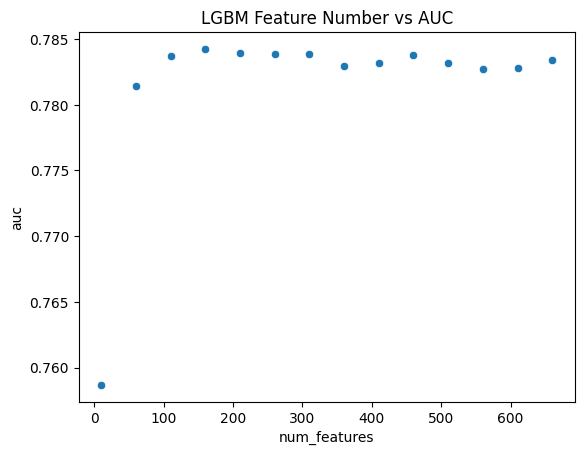

In [87]:
sns.scatterplot(data=evaluate_feature_counts_fi, x='num_features', y='auc').set_title('LGBM Feature Number vs AUC');

Saving the top 400 features for later use: 

In [88]:
top_400_fi = feature_importance_lgbm['feature'].to_list()[:400]
x_fi_400 = x_train[top_400_fi]
x_fi_val_400 = x_val[top_400_fi]
x_fi_400.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,credit_annuity_ratio,DAYS_EMPLOYED,age_score_ratio,p_NUM_ip_NUM_AMT_PAYMENT_min_mean,DAYS_BIRTH,score_credit_ratio,NAME_EDUCATION_TYPE_Higher_education,...,prev_cat_CNT_NAME_CONTRACT_TYPE_Cash_loans,LAST3_POS_NUM_MONTHS_BALANCE_max_std,LAST3_POS_CNT_NAME_CONTRACT_STATUS_Signed_std,LAST3_ccb_NUM_CNT_DRAWINGS_CURRENT_std_max,LAST3_ccb_NUM_AMT_DRAWINGS_CURRENT_std_mean,p_NUM_ip_NUM_DAYS_ENTRY_PAYMENT_max_mean,p_NUM_ccb_NUM_AMT_BALANCE_mean_max,LAST3_POS_NUM_credit_term_ratio_std_max,OBS_30_CNT_SOCIAL_CIRCLE,ENTRANCES_MODE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
310536,0.622922,0.289573,0.384582,17.250085,-946.0,-31977.575331,5489.34300,-12298,1.272735e-06,1,...,2.0,9.899495,0.0,1.532194,56819.262327,-876.6,213473.232857,0.360041,0.0,0.2759
365516,NaN,0.514261,NaN,12.350515,-92.0,0.000000,8504.98875,-15375,3.179751e-06,0,...,2.0,2.121320,0.0,NaN,NaN,-130.0,NaN,0.390021,2.0,NaN
242055,0.598926,0.486906,NaN,27.705440,-1646.0,0.000000,12985.47000,-19307,6.680499e-07,0,...,0.0,NaN,NaN,NaN,NaN,-2394.0,NaN,0.395285,1.0,0.1379
454894,0.454321,0.675705,NaN,13.690269,-1651.0,0.000000,7373.58300,-17791,1.424987e-06,0,...,6.0,NaN,NaN,NaN,NaN,-1305.8,NaN,NaN,2.0,0.0345
448321,NaN,0.154565,NaN,9.242325,-977.0,0.000000,3102.61500,-8486,6.068521e-07,0,...,1.0,NaN,NaN,NaN,NaN,-374.0,NaN,0.312731,0.0,NaN


Finding the maximum number of features found with this method: 

In [89]:
evaluate_feature_counts_fi.loc[evaluate_feature_counts_fi['auc'].idxmax()]

num_features    160.00000
auc               0.78426
Name: 3, dtype: float64

The best number of features with this method is found to be 160. Evaluating a model with these top features gives: 

In [90]:
features_fi = feature_importance_lgbm['feature'].to_list()[:160]
x_fi = x_train[features_fi]
x_fi_val = x_val[features_fi]


Evaluating a model with these selected features: 

In [91]:
r_fi = get_results(models_1, x_fi, y_train, cv)
r_fi

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7843 ± 0.0018,0.2722 ± 0.0051,0.7320 ± 0.0013,0.9019 ± 0.0006,0.7320 ± 0.0013,0.7910 ± 0.0010,0.2552 ± 0.0034


This auc is about 0.001 higher than for the previous best model.

## SHAP

Next, the same procedure can be done with SHAP values, as results from feature importance and SHAP and selection methods can differ. 

In [92]:
explainer = shap.TreeExplainer(model_lgbm_fit)
shap_matrix = explainer(x_train, check_additivity=False).values
if isinstance(shap_matrix, list):
    shap_matrix = shap_matrix[1]     
mean_abs_shap = np.abs(shap_matrix).mean(axis=0)

shap_importance_df = (
    pd.DataFrame({
        "feature": x_train.columns,
        "mean_abs_shap": mean_abs_shap,
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)
shap_importance_df.head(5)

,feature,mean_abs_shap
0,EXT_SOURCE_3,0.301091
1,EXT_SOURCE_2,0.298964
2,EXT_SOURCE_1,0.145606
3,DAYS_EMPLOYED,0.119816
4,credit_annuity_ratio,0.086457


Looking at the SHAP summary plot to see the top features: 


SHAP summary plot for LightGBM:


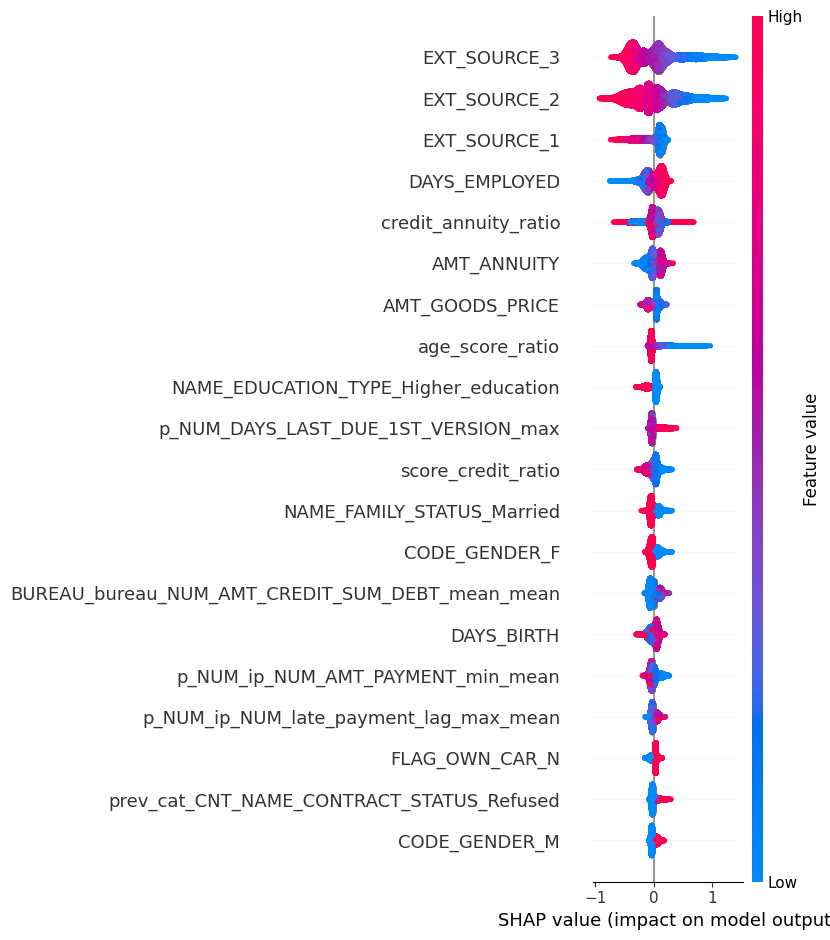

In [93]:
print("\nSHAP summary plot for LightGBM:")
fig, ax = plt.subplots()
shap.summary_plot(
    shap_matrix,               
    features=x_train,
    feature_names=x_train.columns.tolist(),
    max_display=20,             
    show=False
)
plt.show()

Again, top features include external source variables (1, 2, and 3)- follow the same trend as seen in the previous notebook: low scores lead to clients defaulting, and high scores give a higher probability of not-defaulting. Time employed is another top feature here, where less time employed seems to lead to clients defaulting less often. Numerical features describing a client's current application amounts are also found to be top features (credit_annuity_ratio, AMT_ANNUITY, AMT_GOODS_PRICE).

Now, iterating through the top SHAP features to find the optimal number of features for this model: 

In [94]:
evaluate_feature_counts_shap = evaluate_feature_counts(
    model_lgbm, x_train, y_train, shap_importance_df['feature'], cv, metric='roc_auc'
)   

Evaluating top 10 features...
Evaluating top 60 features...
Evaluating top 110 features...
Evaluating top 160 features...
No improvement for 1 iteration(s)
Evaluating top 210 features...
No improvement for 2 iteration(s)
Evaluating top 260 features...
No improvement for 3 iteration(s)
Evaluating top 310 features...
No improvement for 4 iteration(s)
Evaluating top 360 features...
No improvement for 5 iteration(s)
Evaluating top 410 features...
No improvement for 6 iteration(s)
Evaluating top 460 features...
No improvement for 7 iteration(s)
Evaluating top 510 features...
No improvement for 8 iteration(s)
Evaluating top 560 features...
No improvement for 9 iteration(s)
Evaluating top 610 features...
No improvement for 10 iteration(s)
Stopping early after 10 non-improving iterations.


Looking at this in a scatterplot: 

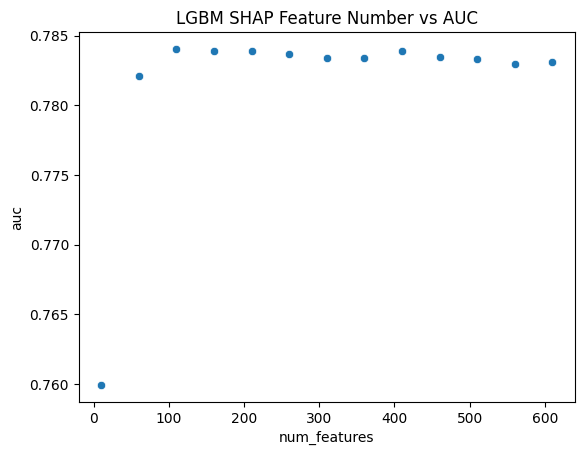

In [95]:
sns.scatterplot(data=evaluate_feature_counts_shap, x='num_features', y='auc').set(title='LGBM SHAP Feature Number vs AUC');

Saving the top 400 features for later use: 

In [96]:
top_shap_400 = shap_importance_df['feature'].to_list()[:400]
x_shap_400 = x_train[top_shap_400]
x_shap_400_val = x_val[top_shap_400]
x_shap_400.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_EMPLOYED,credit_annuity_ratio,AMT_ANNUITY,AMT_GOODS_PRICE,age_score_ratio,NAME_EDUCATION_TYPE_Higher_education,p_NUM_DAYS_LAST_DUE_1ST_VERSION_max,...,LAST3_POS_NUM_CNT_INSTALMENT_mean_mean,prev_cat_CNT_NAME_CASH_LOAN_PURPOSE_XAP,LAST3_POS_NUM_CNT_INSTALMENT_std_max,LAST1_ip_NUM_NUM_INSTALMENT_VERSION_std_mean,LAST3_ip_NUM_AMT_INSTALMENT_max_std,prev_cat_CNT_WEEKDAY_APPR_PROCESS_START_THURSDAY,LAST3_DAYS_LAST_DUE_mean,LAST3_ip_NUM_DAYS_ENTRY_PAYMENT_max_std,LAST1_AMT_ANNUITY_mean,p_NUM_ccb_NUM_AMT_BALANCE_std_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
310536,0.622922,0.289573,0.384582,-946.0,17.250085,13189.5,180000.0,-31977.575331,1,-286.0,...,9.000000,3.0,0.000000,0.0,4697.729637,0.0,-499.5,349.680330,22500.000,162293.808217
365516,NaN,0.514261,NaN,-92.0,12.350515,13095.0,135000.0,0.000000,0,205.0,...,8.916667,4.0,0.408248,NaN,2412.545807,1.0,-148.0,102.530483,NaN,NaN
242055,0.598926,0.486906,NaN,-1646.0,27.705440,26307.0,553500.0,0.000000,0,-2390.0,...,4.000000,1.0,0.000000,0.0,NaN,1.0,-2390.0,NaN,12991.005,NaN
454894,0.454321,0.675705,NaN,-1651.0,13.690269,34636.5,391500.0,0.000000,0,295.0,...,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,23493.690,NaN
448321,NaN,0.154565,NaN,-977.0,9.242325,27558.0,225000.0,0.000000,0,-334.0,...,11.916667,1.0,0.288675,NaN,NaN,0.0,-364.0,NaN,NaN,NaN


Finding the exact optimal number of features found with this method: 

In [97]:
evaluate_feature_counts_shap.loc[evaluate_feature_counts_shap['auc'].idxmax()]

num_features    110.000000
auc               0.784049
Name: 2, dtype: float64

The best number of features with this method is found to be 110. Evaluating a model with these top features gives: 

In [98]:
features_shap = shap_importance_df['feature'].to_list()[:110]
x_shap = x_train[features_shap]
x_shap_val = x_val[features_shap]


In [99]:
r_shap = get_results(models_1, x_shap, y_train, cv)
r_shap

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7840 ± 0.0020,0.2707 ± 0.0051,0.7298 ± 0.0011,0.9016 ± 0.0004,0.7298 ± 0.0011,0.7894 ± 0.0008,0.2529 ± 0.0021


This gives a slightly lower but almost identical auc value as compared to the model with selected feature importance features (0.7843).

## Recursive feature elimination with cross validation: 

Now that the top features have been established, recursive feature elimination can be used for comparison purposes: 

### Using the top 400 feature importance features: 

The top 400 features of both selection methods (feature importance and shap values) are chosen and evaluated with this method, starting with the top 400 feature importance features: 

In [100]:
model_lgbm = LGBMClassifier(
    random_state=42,
    class_weight=class_weight_dict,
    objective='binary',
    metric='auc',
    verbose=-1
)

rfecv = RFECV(
    estimator=model_lgbm,
    step=25,
    cv=cv,
    scoring='roc_auc',
    n_jobs=1,
    min_features_to_select=20
)

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message="X does not have valid feature names, but.*",
        category=UserWarning),
    warnings.filterwarnings("ignore", category=InconsistentVersionWarning)
    rfecv.fit(x_fi_400, y_train)
optimal_features_fi = x_fi_400.columns[rfecv.support_]
x_rfe_fi = x_fi_400[optimal_features_fi]
x_rfe_fi_val = x_fi_val_400[optimal_features_fi]

print(f"Selected {len(optimal_features_fi)} optimal features.")


Selected 275 optimal features.


275 features have been selected. Looking at this in a plot: 

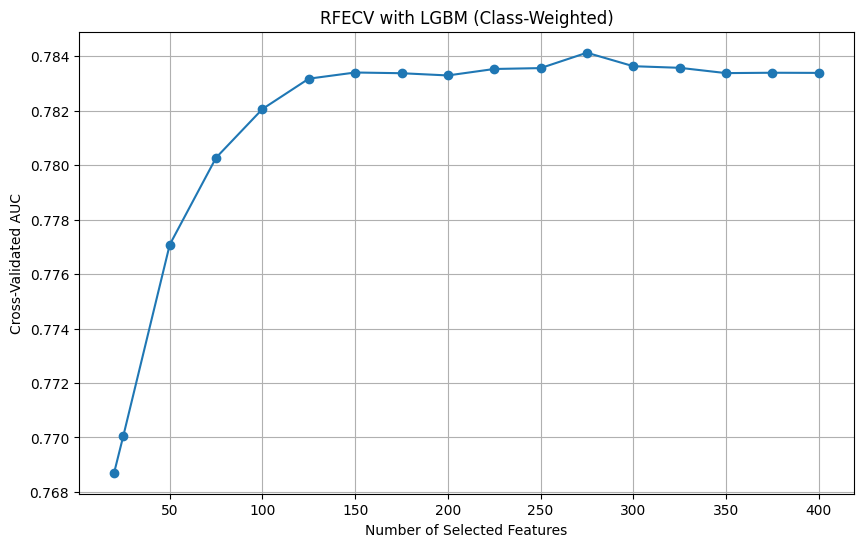

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(rfecv.cv_results_['n_features'], rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validated AUC")
plt.title("RFECV with LGBM (Class-Weighted)")
plt.grid(True)
plt.show()


Evaluating results of the dataframe with the selected recursive feature elimination results: 

In [102]:
r_rfe_fi = get_results(models_1, x_rfe_fi, y_train, cv)
r_rfe_fi

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7835 ± 0.0021,0.2714 ± 0.0054,0.7321 ± 0.0015,0.9014 ± 0.0003,0.7321 ± 0.0015,0.7910 ± 0.0011,0.2530 ± 0.0020


This auc is a little lower than that found using feature importance or shap values, and about the same as the model with all features. 

### Using the top 400 SHAP features: 

Evaluating top features in the same way as before: 

In [103]:
rfecv = RFECV(
    estimator=model_lgbm,
    step=25,
    cv=cv,
    scoring='roc_auc',
    n_jobs=1,
    min_features_to_select=20
)

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message="X does not have valid feature names, but.*",
        category=UserWarning),
    warnings.filterwarnings("ignore", category=InconsistentVersionWarning)
    rfecv.fit(x_shap_400, y_train)
optimal_features_shap = x_shap_400.columns[rfecv.support_]
x_rfe_shap = x_shap_400[optimal_features_shap]
x_rfe_shap_val = x_shap_400_val[optimal_features_shap]

print(f"Selected {len(optimal_features_shap)} optimal features.")


Selected 375 optimal features.


Looking at the results: 

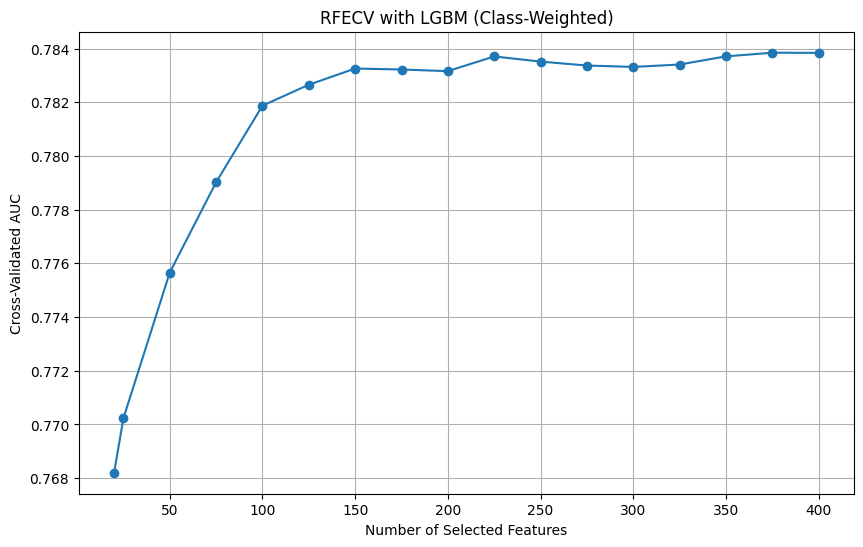

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(rfecv.cv_results_['n_features'], rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validated AUC")
plt.title("RFECV with LGBM (Class-Weighted)")
plt.grid(True)
plt.show()


Evaluating the results in the same way as in the rest of the project: 

In [105]:
r_rfe_shap = get_results(models_1, x_rfe_shap, y_train, cv)
r_rfe_shap

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,lightgbm,0.7838 ± 0.0024,0.2719 ± 0.0061,0.7328 ± 0.0013,0.9016 ± 0.0006,0.7328 ± 0.0013,0.7915 ± 0.0010,0.2539 ± 0.0027


This is also a little lower than results found with feature importance or shap selected features, but a little higher than the model with all features. 

Now, validation data can be used to see which feature set generalizes the best: 

In [106]:
results = {
    'SHAP': evaluate_feature_subset(x_shap, y_train, x_shap_val, y_val, features_shap, class_weight_dict),
    'Feature Importance': evaluate_feature_subset(x_fi, y_train, x_fi_val, y_val, features_fi, class_weight_dict),
    'RFE_fi': evaluate_feature_subset(x_rfe_fi, y_train, x_rfe_fi_val, y_val, optimal_features_fi, class_weight_dict),
    'RFE_shap': evaluate_feature_subset(x_rfe_shap, y_train, x_rfe_shap_val, y_val, optimal_features_shap, class_weight_dict)
}
print("AUC scores for different feature selection methods:")
pd.Series(results).sort_values(ascending=False)


AUC scores for different feature selection methods:


RFE_shap              0.787173
SHAP                  0.786603
Feature Importance    0.786411
RFE_fi                0.786395
dtype: float64

As the RFE_shap features have the highest auc for the validation data, they will be used from here:

In [107]:
x_final = x_rfe_shap.copy()
x_final_val = x_rfe_shap_val.copy()

Printing the list of optimal features to use for the test_data notebook: 

In [108]:
optimal_features_shap.to_list()

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'DAYS_EMPLOYED',
 'credit_annuity_ratio',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'age_score_ratio',
 'NAME_EDUCATION_TYPE_Higher_education',
 'p_NUM_DAYS_LAST_DUE_1ST_VERSION_max',
 'score_credit_ratio',
 'NAME_FAMILY_STATUS_Married',
 'CODE_GENDER_F',
 'BUREAU_bureau_NUM_AMT_CREDIT_SUM_DEBT_mean_mean',
 'DAYS_BIRTH',
 'p_NUM_ip_NUM_AMT_PAYMENT_min_mean',
 'p_NUM_ip_NUM_late_payment_lag_max_mean',
 'FLAG_OWN_CAR_N',
 'prev_cat_CNT_NAME_CONTRACT_STATUS_Refused',
 'CODE_GENDER_M',
 'BUREAU_bureau_NUM_AMT_CREDIT_MAX_OVERDUE_mean_mean',
 'BUREAU_bureau_CNT_CREDIT_ACTIVE_Closed_mean',
 'prev_cat_CNT_NAME_YIELD_GROUP_low_action',
 'LAST3_ip_NUM_late_payment_lag_max_mean',
 'ORGANIZATION_TYPE_GROUPED_Public_Sector',
 'BUREAU_bureau_NUM_credit_usage_mean_mean',
 'SUM_FLAG_DOCUMENT',
 'AMT_CREDIT',
 'REGION_RATING_CLIENT_W_CITY',
 'p_NUM_AMT_DOWN_PAYMENT_max',
 'prev_cat_CNT_NAME_YIELD_GROUP_high',
 'DAYS_ID_PUBLISH',
 'p_NUM_DAYS_LAST_DUE_1ST_V

## Shap values for selected features

Now that the optimal feature number has been selected, SHAP feature importance can be examined again to ensure that the top features have not changed: 

SHAP summary plot for best light-gbm:


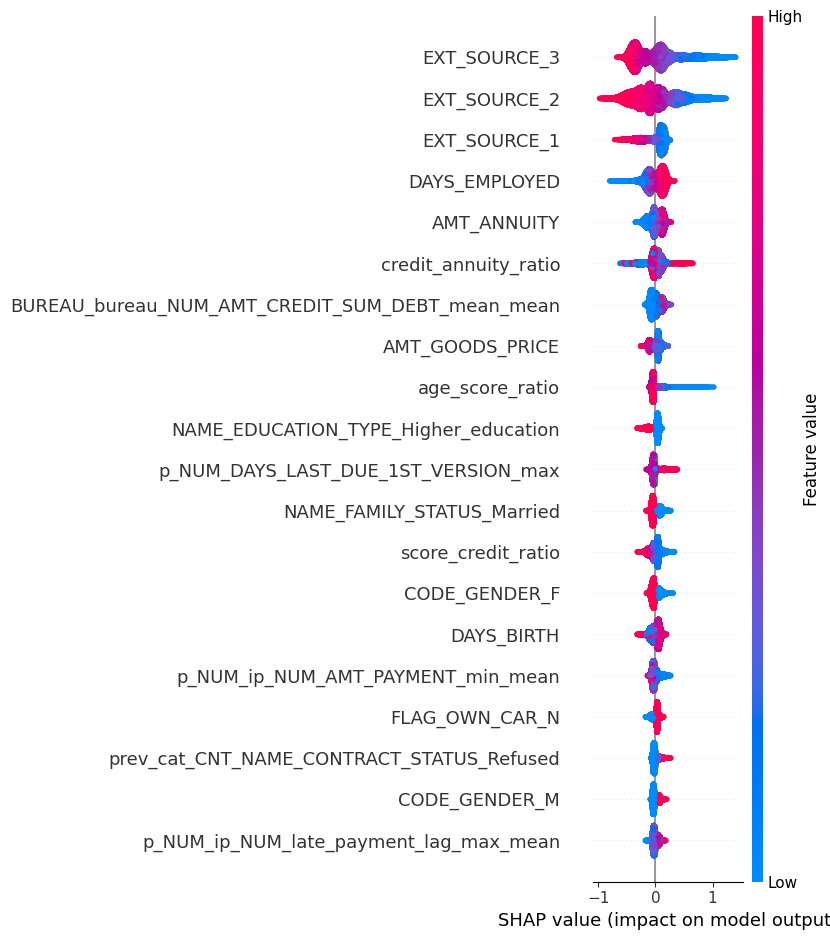

In [109]:
model = LGBMClassifier(
    random_state=42,
    class_weight=class_weight_dict,
    objective='binary',
    metric='auc',
    verbose=-1
).fit(x_final, y_train)

explainer = shap.TreeExplainer(model) 
shap_matrix = explainer(x_final, check_additivity=False).values
if isinstance(shap_matrix, list):
    shap_matrix = shap_matrix[1]     
mean_abs_shap = np.abs(shap_matrix).mean(axis=0)


print("SHAP summary plot for best light-gbm:")
fig, ax = plt.subplots()
shap.summary_plot(
    shap_matrix,               
    features=x_final,
    feature_names=x_final.columns.tolist(),
    max_display=20,             
    show=False
)
plt.show()

Now, the AMT_CREDIT_SUM_DEBT variable from the bureau table’s importance has increased. This variable indicates the current amount of debt that a client has with the credit bureau at the time of application for a Home Credit loan, and the SHAP plot shows that having lower average amounts here also decrease the model's prediction probability that the client will default on a loan. All features found here are still all the same as in the first SHAP plot. 

# Hyperparameter tuning: 

Now that an optimal number of features has been selected, the top three models can be tuned: light-gbm, hist-gradient-boosted model, and catboost model. Bayes hyperparameter tuning is used here. 

## Hyperparameter tuning for light-gbm: 

In [ ]:
param_space_lgbm = {
    'n_estimators': (100, 400),
    'max_depth': (1, 15),
    'num_leaves': (10, 100),
    'learning_rate': (0.01, 0.3),
    'min_child_samples': (15, 70),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'lambda_l1': (0.0, 20.0),  
    'lambda_l2': (0.0, 20.0),  
}

lgbm = LGBMClassifier(random_state=42, class_weight=class_weight_dict, objective='binary', metric='auc', verbose=-1)

bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=param_space_lgbm,
    n_iter=50,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

bayes_search.fit(x_final, y_train)
print("Best Parameters:", bayes_search.best_params_)
best_lgbm = bayes_search.best_estimator_
r_tuning_lgb = get_results({'best_lgbm': best_lgbm}, x_final, y_train, cv)
r_tuning = pd.concat([r_tuning_lgb, r_initial_aggregation], ignore_index=True)
r_tuning


Best Parameters: OrderedDict({'colsample_bytree': 0.8479631387263906, 'lambda_l1': 16.357443685351413, 'lambda_l2': 20.0, 'learning_rate': 0.05282117923222041, 'max_depth': 12, 'min_child_samples': 50, 'n_estimators': 400, 'num_leaves': 15, 'subsample': 0.6105123344874124})


,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,best_lgbm,0.7877 ± 0.0027,0.2781 ± 0.0060,0.7332 ± 0.0024,0.9025 ± 0.0007,0.7332 ± 0.0024,0.7919 ± 0.0018,0.2581 ± 0.0038
1,lightgbm,0.7834 ± 0.0022,0.2709 ± 0.0068,0.7344 ± 0.0020,0.9015 ± 0.0009,0.7344 ± 0.0020,0.7927 ± 0.0015,0.2545 ± 0.0049


This tuned model has better performance than the original light-gb model by about 0.004. 

## Hyperparameter tuning for HistGradientBoosting: 

The same method is used for this hist gradient boosted model: 

In [ ]:
param_space_hgb = {
    'learning_rate': Real(0.01, 0.2),
    'max_iter': Integer(200, 500),
    'max_depth': Integer(1, 15),
    'min_samples_leaf': Integer(5, 30),
    'l2_regularization': Real(0.0, 10.0),
    'max_leaf_nodes': Integer(15, 100),
}

hgb = HistGradientBoostingClassifier(random_state=42, class_weight=class_weight_dict)

bayes_search = BayesSearchCV(
    estimator=hgb,
    search_spaces=param_space_hgb,
    n_iter=50, 
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
    random_state=42
)

bayes_search.fit(x_final, y_train)
print("Best Parameters:", bayes_search.best_params_)
best_hgb = bayes_search.best_estimator_
new_row = get_results({'best_hgb': best_hgb}, x_final, y_train, cv)
r_tuning = pd.concat([r_tuning_lgb, new_row], ignore_index=True)
r_tuning

Best Parameters: OrderedDict({'l2_regularization': 4.154831052769809, 'learning_rate': 0.03553952363511499, 'max_depth': 7, 'max_iter': 376, 'max_leaf_nodes': 31, 'min_samples_leaf': 6})


,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,best_lgbm,0.7877 ± 0.0027,0.2781 ± 0.0060,0.7332 ± 0.0024,0.9025 ± 0.0007,0.7332 ± 0.0024,0.7919 ± 0.0018,0.2581 ± 0.0038
1,best_hgb,0.7853 ± 0.0021,0.2742 ± 0.0046,0.7433 ± 0.0029,0.9014 ± 0.0005,0.7433 ± 0.0029,0.7989 ± 0.0020,0.2578 ± 0.0022


The lgbm model still has the best performance. 

## Hyperparameter tuning for catboost: 

The same method is used for the catboost model: 

In [ ]:
model_cat =  CatBoostClassifier(
    random_state=42,
    class_weights=class_weight_dict,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0
)

param_space_catboost = {
    'learning_rate': Real(0.01, 0.2),
    'depth': Integer(4, 10),
    'l2_leaf_reg': Real(1, 10),
    'iterations': Integer(100, 500),
    'border_count': Integer(32, 255),  
    'bagging_temperature': Real(0, 1),
    'random_strength': Real(0.1, 10)
}

bayes_search = BayesSearchCV(
    estimator=model_cat,
    search_spaces=param_space_catboost,
    n_iter=50,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

bayes_search.fit(x_final, y_train)

print("Best Parameters:", bayes_search.best_params_)
best_cbc = bayes_search.best_estimator_

new_row = get_results({'best_catboost': best_cbc}, x_final, y_train, cv)
r_tuning = pd.concat([r_tuning, new_row], ignore_index=True)
r_tuning

Best Parameters: OrderedDict({'bagging_temperature': 1.0, 'border_count': 255, 'depth': 4, 'iterations': 500, 'l2_leaf_reg': 10.0, 'learning_rate': 0.12585676755376476, 'random_strength': 10.0})


,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,best_lgbm,0.7877 ± 0.0027,0.2781 ± 0.0060,0.7332 ± 0.0024,0.9025 ± 0.0007,0.7332 ± 0.0024,0.7919 ± 0.0018,0.2581 ± 0.0038
1,best_hgb,0.7853 ± 0.0021,0.2742 ± 0.0046,0.7433 ± 0.0029,0.9014 ± 0.0005,0.7433 ± 0.0029,0.7989 ± 0.0020,0.2578 ± 0.0022
2,best_catboost,0.7870 ± 0.0017,0.2761 ± 0.0052,0.7372 ± 0.0019,0.9020 ± 0.0008,0.7372 ± 0.0019,0.7947 ± 0.0014,0.2581 ± 0.0037


The catboost and lgbm models have similar performance. 

# Ensemble models: 

## Stacking: 

Now that the three top models have been tuned, they can be stacked together to see if this increases model output: 

In [ ]:
final_estimator = CatBoostClassifier(
    iterations=150,
    depth=3,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    verbose=0,
    random_seed=42
)
stacked_model = StackingClassifier(
    estimators=[
        ("lgbm", best_lgbm),
        ("catboost", best_cbc),
        ("hgb", best_hgb),
    ],
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

stacked_model.fit(x_final, y_train)

new_row = get_results({'Stacked_model': stacked_model}, x_final, y_train, cv)
r_tuning = pd.concat([r_tuning_lgb, new_row], ignore_index=True)

In [ ]:
r_tuning

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,best_lgbm,0.7877 ± 0.0027,0.2781 ± 0.0060,0.7332 ± 0.0024,0.9025 ± 0.0007,0.7332 ± 0.0024,0.7919 ± 0.0018,0.2581 ± 0.0038
1,Stacked_model,0.7894 ± 0.0022,0.2780 ± 0.0040,0.7071 ± 0.0054,0.9042 ± 0.0007,0.7071 ± 0.0054,0.7730 ± 0.0039,0.2539 ± 0.0027


This does give a higher auc value than any of the other models. The recall and accuracy of the stacked model is lower than the others (best lgbm recall is 0.733 and stacked recall is 0.707).

## Voting model

A blended model can also be implemented with the tuned catboost, hist-gb, and light-gb models: 

In [ ]:
voting = VotingClassifier(
    estimators=[
        ('lgbm', best_lgbm),
        ('cat', best_cbc),
        ('hgb', best_hgb)
    ],
    voting='soft',  
    weights=[3, 3, 2], 
    n_jobs=-1
)

voting.fit(x_final, y_train)

new_row = get_results({'Voting_model': voting}, x_final, y_train, cv)
r_tuning = pd.concat([r_tuning, new_row], ignore_index=True)

In [ ]:
r_tuning

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,best_lgbm,0.7877 ± 0.0027,0.2781 ± 0.0060,0.7332 ± 0.0024,0.9025 ± 0.0007,0.7332 ± 0.0024,0.7919 ± 0.0018,0.2581 ± 0.0038
1,Stacked_model,0.7894 ± 0.0022,0.2780 ± 0.0040,0.7071 ± 0.0054,0.9042 ± 0.0007,0.7071 ± 0.0054,0.7730 ± 0.0039,0.2539 ± 0.0027
2,Voting_model,0.7894 ± 0.0022,0.2802 ± 0.0054,0.7393 ± 0.0023,0.9024 ± 0.0005,0.7393 ± 0.0023,0.7962 ± 0.0016,0.2609 ± 0.0025


The voting model now has the highest auc (0.7924) and highest pr-auc (0.292), weighted f1 score (0.795), mcc (0.264) with high overall recall (0.737). Based on this high combination of metrics, this is a good candidate for deployment. However, it is important to keep in mind that having good explainability is important for this dataset also. Ensemble models intrinsically have lower explainability than having one model alone (catboost or light-gb). 

# Testing on holdout data: 

Finally, each model can be tested with the validation data. For each model, the classification report is printed, and results are calculated and added to the results table. 

For this application, correctly classifying positive cases is very important, as a high business cost results from a customer defaulting on a loan. Therefore, the optimal model for this problem will have a high auc value as well as high recall. Precision is still important, as having false positives also means that Home Credit is losing business and denies loans to customers unfairly. 


## Light-gb model

In [ ]:
y_pred = best_lgbm.predict(x_final_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     56538
           1       0.19      0.71      0.30      4965

    accuracy                           0.73     61503
   macro avg       0.58      0.72      0.57     61503
weighted avg       0.90      0.73      0.79     61503



The precision for the light-gb model is quite low and means that only 19% of predicted defaulters actually default on their loan. However, this model catches 71% of actual defaulters. 

In [ ]:
y_holdout_proba = best_lgbm.predict_proba(x_final_val)[:, 1]
metrics_results = {
    "AUC": roc_auc_score(y_val, y_holdout_proba),
    "PR_AUC": average_precision_score(y_val, y_holdout_proba),
    "RECALL": recall_score(y_val, y_pred, average="weighted"),
    "PRECISION": precision_score(y_val, y_pred, average="weighted", zero_division=0),
    "ACCURACY": accuracy_score(y_val, y_pred),
    "WEIGHTED_F1": f1_score(y_val, y_pred, average="weighted"),
    "MCC": matthews_corrcoef(y_val, y_pred),
}

model_name = "Best lgb holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r_tuning.columns)


r_tuning = pd.concat([r_tuning, model_results], ignore_index=True)
r_tuning

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,best_lgbm,0.7877 ± 0.0027,0.2781 ± 0.0060,0.7332 ± 0.0024,0.9025 ± 0.0007,0.7332 ± 0.0024,0.7919 ± 0.0018,0.2581 ± 0.0038
1,Stacked_model,0.7894 ± 0.0022,0.2780 ± 0.0040,0.7071 ± 0.0054,0.9042 ± 0.0007,0.7071 ± 0.0054,0.7730 ± 0.0039,0.2539 ± 0.0027
2,Voting_model,0.7894 ± 0.0022,0.2802 ± 0.0054,0.7393 ± 0.0023,0.9024 ± 0.0005,0.7393 ± 0.0023,0.7962 ± 0.0016,0.2609 ± 0.0025
3,Best lgb holdout,0.790296,0.288901,0.733119,0.903556,0.733119,0.791919,0.262997


Quite a high auc is found here with fairly high recall and precision, and a matthews correlation coefficient of 0.26 (one of the highest) which could make this model a good candidate for deployment.

## Hist-gb model: 

Looking at hist-gb's classification report: 

In [ ]:
y_pred = best_hgb.predict(x_final_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84     56538
           1       0.19      0.69      0.30      4965

    accuracy                           0.74     61503
   macro avg       0.58      0.72      0.57     61503
weighted avg       0.90      0.74      0.80     61503



Looking at the row for defaulting (1) clients only: the precision is the same as for the light-gb model, while recall has dropped from 0.71 to 0.69. 

In [ ]:
y_holdout_proba = best_hgb.predict_proba(x_final_val)[:, 1]
metrics_results = {
    "AUC": roc_auc_score(y_val, y_holdout_proba),
    "PR_AUC": average_precision_score(y_val, y_holdout_proba),
    "RECALL": recall_score(y_val, y_pred, average="weighted"),
    "PRECISION": precision_score(y_val, y_pred, average="weighted", zero_division=0),
    "ACCURACY": accuracy_score(y_val, y_pred),
    "WEIGHTED_F1": f1_score(y_val, y_pred, average="weighted"),
    "MCC": matthews_corrcoef(y_val, y_pred),
}

model_name = "Best hgb-holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r_tuning.columns)


r_tuning = pd.concat([r_tuning, model_results], ignore_index=True)
r_tuning

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,best_lgbm,0.7877 ± 0.0027,0.2781 ± 0.0060,0.7332 ± 0.0024,0.9025 ± 0.0007,0.7332 ± 0.0024,0.7919 ± 0.0018,0.2581 ± 0.0038
1,Stacked_model,0.7894 ± 0.0022,0.2780 ± 0.0040,0.7071 ± 0.0054,0.9042 ± 0.0007,0.7071 ± 0.0054,0.7730 ± 0.0039,0.2539 ± 0.0027
2,Voting_model,0.7894 ± 0.0022,0.2802 ± 0.0054,0.7393 ± 0.0023,0.9024 ± 0.0005,0.7393 ± 0.0023,0.7962 ± 0.0016,0.2609 ± 0.0025
3,Best lgb holdout,0.790296,0.288901,0.733119,0.903556,0.733119,0.791919,0.262997
4,Best hgb-holdout,0.788979,0.286519,0.738387,0.90231,0.738387,0.79558,0.259858


The auc and pr-auc value for this model is a little lower than that of the light-gb model. Overall recall for the tuned hist-gb holdout model is a little higher than that for the light-gb model, though the mcc value is a little lower. The best light-gb model is still the top choice for deployment. 

## Catboost model: 

Looking at the classification report for the catboost model: 

In [ ]:
y_pred = best_cbc.predict(x_final_val)
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.74      0.84     56538
           1       0.19      0.70      0.30      4965

    accuracy                           0.74     61503
   macro avg       0.58      0.72      0.57     61503
weighted avg       0.90      0.74      0.79     61503



Once again, the precision for the defaulting class is the same as in the two previous models. Recall is in between that found for the hist-gb and light-gb models with the same f1 score. 

Looking at main metrics for this test case: 

In [ ]:
y_holdout_proba = best_cbc.predict_proba(x_final_val)[:, 1]
metrics_results = {
    "AUC": roc_auc_score(y_val, y_holdout_proba),
    "PR_AUC": average_precision_score(y_val, y_holdout_proba),
    "RECALL": recall_score(y_val, y_pred, average="weighted"),
    "PRECISION": precision_score(y_val, y_pred, average="weighted", zero_division=0),
    "ACCURACY": accuracy_score(y_val, y_pred),
    "WEIGHTED_F1": f1_score(y_val, y_pred, average="weighted"),
    "MCC": matthews_corrcoef(y_val, y_pred),
}

model_name = "Best cat-holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r_tuning.columns)


r_tuning = pd.concat([r_tuning, model_results], ignore_index=True)
r_tuning

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,best_lgbm,0.7877 ± 0.0027,0.2781 ± 0.0060,0.7332 ± 0.0024,0.9025 ± 0.0007,0.7332 ± 0.0024,0.7919 ± 0.0018,0.2581 ± 0.0038
1,Stacked_model,0.7894 ± 0.0022,0.2780 ± 0.0040,0.7071 ± 0.0054,0.9042 ± 0.0007,0.7071 ± 0.0054,0.7730 ± 0.0039,0.2539 ± 0.0027
2,Voting_model,0.7894 ± 0.0022,0.2802 ± 0.0054,0.7393 ± 0.0023,0.9024 ± 0.0005,0.7393 ± 0.0023,0.7962 ± 0.0016,0.2609 ± 0.0025
3,Best lgb holdout,0.790296,0.288901,0.733119,0.903556,0.733119,0.791919,0.262997
4,Best hgb-holdout,0.788979,0.286519,0.738387,0.90231,0.738387,0.79558,0.259858
5,Best cat-holdout,0.790939,0.288516,0.736533,0.903613,0.736533,0.794369,0.264862


The catboost model's auc (0.7909) is slightly better to that found with the light-gb model (0.7903), with slightly better recall, weighted f1 score and MCC value. This could be a better candidate for deployment.

## Stacked model: 

Looking at the classification report for the stacked model: 

In [ ]:
y_pred = stacked_model.predict(x_final_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.70      0.81     56538
           1       0.18      0.74      0.29      4965

    accuracy                           0.71     61503
   macro avg       0.57      0.72      0.55     61503
weighted avg       0.90      0.71      0.77     61503



As compared to the previous models, the defaulting class precision has decreased here, while recall has gone up (0.74 from 0.71).

In [ ]:
y_holdout_proba = stacked_model.predict_proba(x_final_val)[:, 1]
metrics_results = {
    "AUC": roc_auc_score(y_val, y_holdout_proba),
    "PR_AUC": average_precision_score(y_val, y_holdout_proba),
    "RECALL": recall_score(y_val, y_pred, average="weighted"),
    "PRECISION": precision_score(y_val, y_pred, average="weighted", zero_division=0),
    "ACCURACY": accuracy_score(y_val, y_pred),
    "WEIGHTED_F1": f1_score(y_val, y_pred, average="weighted"),
    "MCC": matthews_corrcoef(y_val, y_pred),
}

model_name = "Stacked model holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r_tuning.columns)


r_tuning = pd.concat([r_tuning, model_results], ignore_index=True)
r_tuning

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,best_lgbm,0.7877 ± 0.0027,0.2781 ± 0.0060,0.7332 ± 0.0024,0.9025 ± 0.0007,0.7332 ± 0.0024,0.7919 ± 0.0018,0.2581 ± 0.0038
1,Stacked_model,0.7894 ± 0.0022,0.2780 ± 0.0040,0.7071 ± 0.0054,0.9042 ± 0.0007,0.7071 ± 0.0054,0.7730 ± 0.0039,0.2539 ± 0.0027
2,Voting_model,0.7894 ± 0.0022,0.2802 ± 0.0054,0.7393 ± 0.0023,0.9024 ± 0.0005,0.7393 ± 0.0023,0.7962 ± 0.0016,0.2609 ± 0.0025
3,Best lgb holdout,0.790296,0.288901,0.733119,0.903556,0.733119,0.791919,0.262997
4,Best hgb-holdout,0.788979,0.286519,0.738387,0.90231,0.738387,0.79558,0.259858
5,Best cat-holdout,0.790939,0.288516,0.736533,0.903613,0.736533,0.794369,0.264862
6,Stacked model holdout,0.792248,0.290566,0.706031,0.904379,0.706031,0.77225,0.254138


The stacked model has the highest auc (0.792), pr-auc (0.288) and precision (0.904) seen so far. However, overall recall dropped by about 3%.

## Blended model: 

Looking at the classification report for the blended model: 

In [ ]:
y_pred = voting.predict(x_final_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     56538
           1       0.19      0.70      0.30      4965

    accuracy                           0.74     61503
   macro avg       0.58      0.72      0.57     61503
weighted avg       0.90      0.74      0.79     61503



This shows the same values for the defaulting class as the catboost classification report.

In [ ]:
y_holdout_proba = voting.predict_proba(x_final_val)[:, 1]
metrics_results = {
    "AUC": roc_auc_score(y_val, y_holdout_proba),
    "PR_AUC": average_precision_score(y_val, y_holdout_proba),
    "RECALL": recall_score(y_val, y_pred, average="weighted"),
    "PRECISION": precision_score(y_val, y_pred, average="weighted", zero_division=0),
    "ACCURACY": accuracy_score(y_val, y_pred),
    "WEIGHTED_F1": f1_score(y_val, y_pred, average="weighted"),
    "MCC": matthews_corrcoef(y_val, y_pred),
}

model_name = "Voting model holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r_tuning.columns)


r_tuning = pd.concat([r_tuning, model_results], ignore_index=True)
r_tuning

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
0,best_lgbm,0.7877 ± 0.0027,0.2781 ± 0.0060,0.7332 ± 0.0024,0.9025 ± 0.0007,0.7332 ± 0.0024,0.7919 ± 0.0018,0.2581 ± 0.0038
1,Stacked_model,0.7894 ± 0.0022,0.2780 ± 0.0040,0.7071 ± 0.0054,0.9042 ± 0.0007,0.7071 ± 0.0054,0.7730 ± 0.0039,0.2539 ± 0.0027
2,Voting_model,0.7894 ± 0.0022,0.2802 ± 0.0054,0.7393 ± 0.0023,0.9024 ± 0.0005,0.7393 ± 0.0023,0.7962 ± 0.0016,0.2609 ± 0.0025
3,Best lgb holdout,0.790296,0.288901,0.733119,0.903556,0.733119,0.791919,0.262997
4,Best hgb-holdout,0.788979,0.286519,0.738387,0.90231,0.738387,0.79558,0.259858
5,Best cat-holdout,0.790939,0.288516,0.736533,0.903613,0.736533,0.794369,0.264862
6,Stacked model holdout,0.792248,0.290566,0.706031,0.904379,0.706031,0.77225,0.254138
7,Voting model holdout,0.792406,0.292224,0.737411,0.90354,0.737411,0.794991,0.264952


Now, the voting model takes the highest auc (0.7924) by only 0.0002, and also has the highest pr-auc (0.292), weighted f1 score (0.795), mcc (0.264) with high overall recall (0.737). Based on this high combination of metrics, this is a good candidate for deployment. However, it is important to keep in mind that having good explainability is important for this dataset also. Ensemble models intrinsically have lower explainability than having one model alone (catboost or light-gb). 

# Confusion Matrix and model selection: 

Now, a confusion matrix for each model is examined before selecting the best one. 

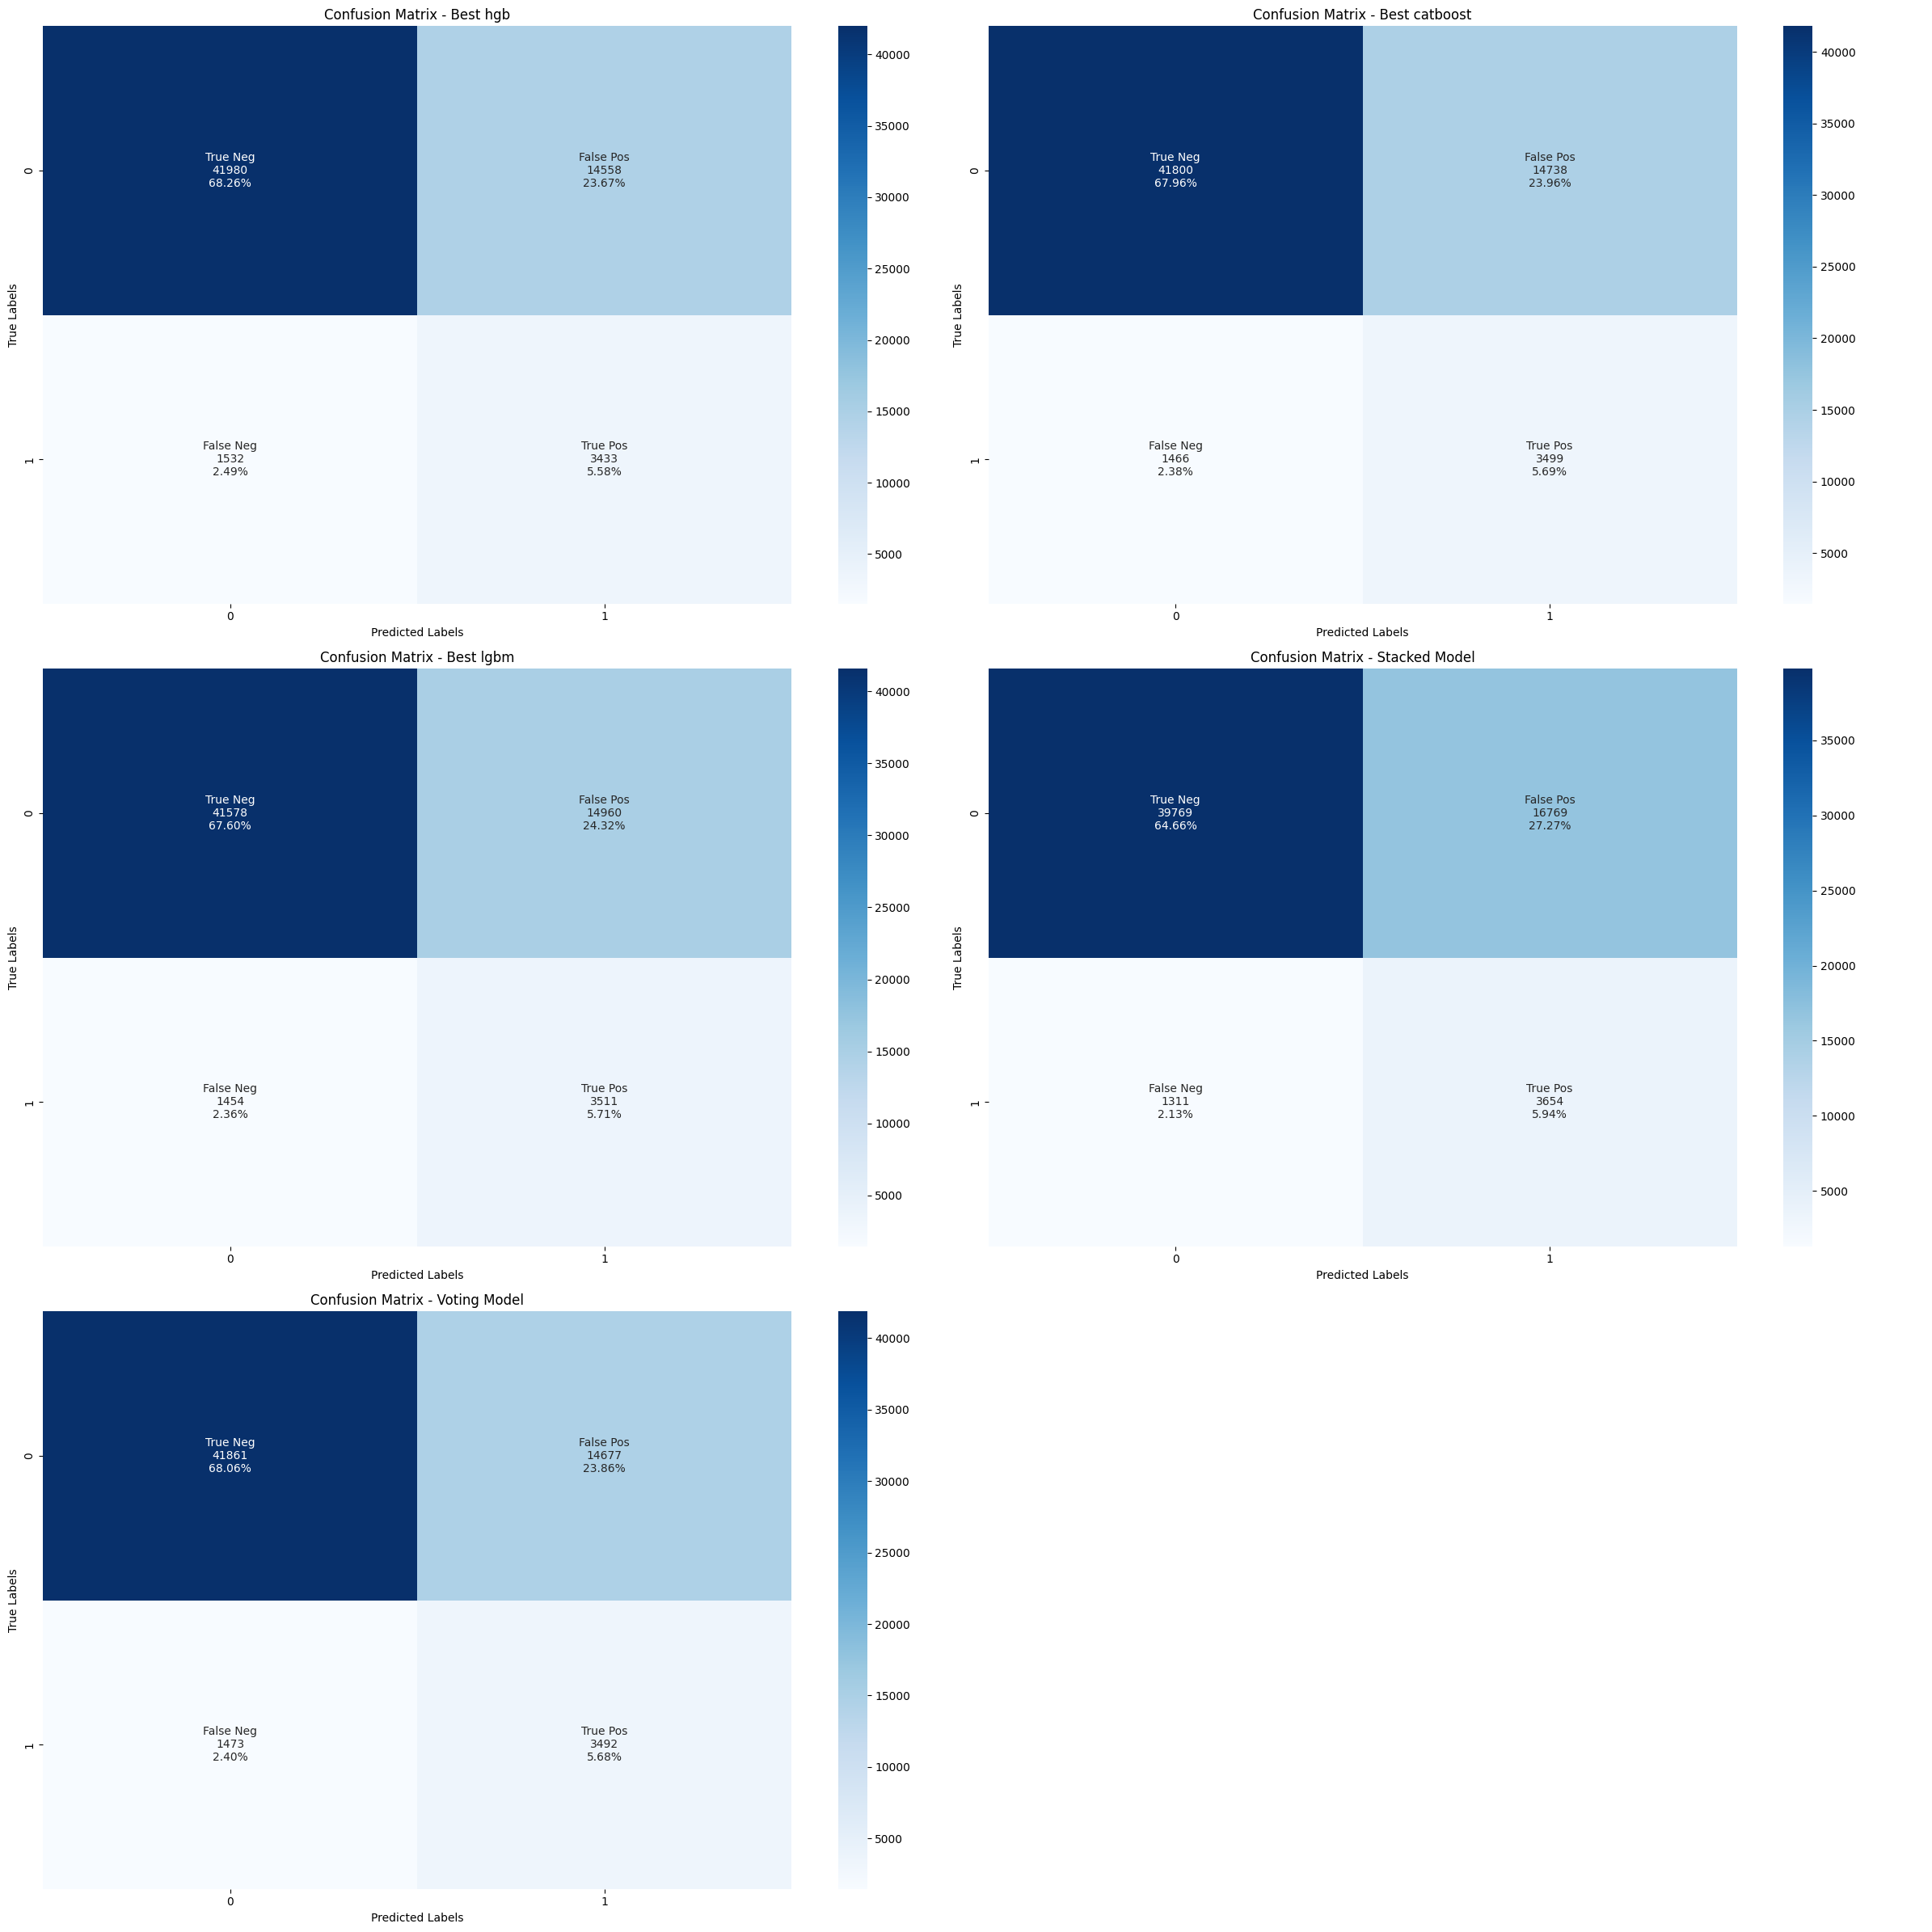

In [ ]:
y_pred_hgb = best_hgb.predict(x_final_val)
y_pred_cat = best_cbc.predict(x_final_val)
y_pred_lgbm = best_lgbm.predict(x_final_val)
y_pred_stacked = stacked_model.predict(x_final_val)
y_pred_voting = voting.predict(x_final_val)

cm_hgb = confusion_matrix(y_val, y_pred_hgb)
cm_cat= confusion_matrix(y_val, y_pred_cat)
cm_lgbm = confusion_matrix(y_val, y_pred_lgbm)
cm_stacked = confusion_matrix(y_val, y_pred_stacked)
cm_voting = confusion_matrix(y_val, y_pred_voting)

labels_hgb = format_cm_labels(cm_hgb)
labels_cat = format_cm_labels(cm_cat)
labels_lgbm = format_cm_labels(cm_lgbm)
labels_stacked = format_cm_labels(cm_stacked)
labels_voting = format_cm_labels(cm_voting)


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 24))

sns.heatmap(cm_hgb, annot=labels_hgb, fmt="", cmap="Blues", ax=axes[0][0])
axes[0][0].set_title("Confusion Matrix - Best hgb")
axes[0][0].set_xlabel("Predicted Labels")
axes[0][0].set_ylabel("True Labels")

sns.heatmap(cm_cat, annot=labels_cat, fmt="", cmap="Blues", ax=axes[0][1])
axes[0][1].set_title("Confusion Matrix - Best catboost")
axes[0][1].set_xlabel("Predicted Labels")
axes[0][1].set_ylabel("True Labels")

sns.heatmap(cm_lgbm, annot=labels_lgbm, fmt="", cmap="Blues", ax=axes[1][0])
axes[1][0].set_title("Confusion Matrix - Best lgbm")
axes[1][0].set_xlabel("Predicted Labels")
axes[1][0].set_ylabel("True Labels")

sns.heatmap(cm_stacked, annot=labels_stacked, fmt="", cmap="Blues", ax=axes[1][1])
axes[1][1].set_title("Confusion Matrix - Stacked Model")
axes[1][1].set_xlabel("Predicted Labels")
axes[1][1].set_ylabel("True Labels")

sns.heatmap(cm_voting, annot=labels_voting, fmt="", cmap="Blues", ax=axes[2][0])
axes[2][0].set_title("Confusion Matrix - Voting Model")
axes[2][0].set_xlabel("Predicted Labels")
axes[2][0].set_ylabel("True Labels")
axes[2][1].axis('off')
plt.tight_layout()
plt.show()



In [ ]:
r_tuning.loc[[3, 4, 5, 6, 7]]

,Model,AUC,PR AUC,RECALL,PRECISION,ACCURACY,WEIGHTED F1,MCC
3,Best lgb holdout,0.790296,0.288901,0.733119,0.903556,0.733119,0.791919,0.262997
4,Best hgb-holdout,0.788979,0.286519,0.738387,0.90231,0.738387,0.79558,0.259858
5,Best cat-holdout,0.790939,0.288516,0.736533,0.903613,0.736533,0.794369,0.264862
6,Stacked model holdout,0.792248,0.290566,0.706031,0.904379,0.706031,0.77225,0.254138
7,Voting model holdout,0.792406,0.292224,0.737411,0.90354,0.737411,0.794991,0.264952


The model with the highest true negative amount is the hist-gradient boosted model (68.26%). This model's overall metrics were not among the top ones, and the hist-gb model's true positive rate is not among the higest. Therefore, this model is not chosen for deployment. In second place for the highest amount of true negatives is the voting model with 68.06%. This model had the highest overall scores in terms of auc and pr-auc 

The model with the highest true positive amount is the stacked model (5.94%). However, as this model has the lowest true negative amount (64.66%), it will not be chosen. The model with the second highest amount of true positives is the light-gbm model (5.71%). 

In terms of the results seen so far with validation data, the model with the highest overall metrics (auc, pr-auc, recall) is the voting model. However, the voting model's performance is slower than that of light-gbm and its explainability is more complex, as it combines all three tested models (catboost, light-gbm and hist-gb). If Home Credit's objective is to have the best model performance, the voting model is the best choice. 

The catboost model's metrics are generally combarable but slightly higher than those found for light-gbm, though this model is also generally slightly slower and complex than light-gbm. The confusion matrix showed that the catboost model had more true negatives (about 200) than the light-gb model, with only 12 less true positives than the light-gbm model. If Home Credit's objective is to have a good model performance without using ensemble models for better explainability, then the catboost model is the best choice. 

However, if the focus is on speed and interpretability, the light-gb model is the best choice, as its metrics are also competitive with the other two models (lgbm's holdout auc is only 0.002 lower than that for the voting model).

In this case, the light-gb model is chosen for deployment here because it has relatively accurate performance, is its the fastest model, and has the best explainability.

# Feature importance of tuned model: 

It is also important to examine feature importances for the tuned models before a final model selection. Here, the light-gb model and catboost top SHAP values are examined: 

SHAP summary plot for best light-gbm:


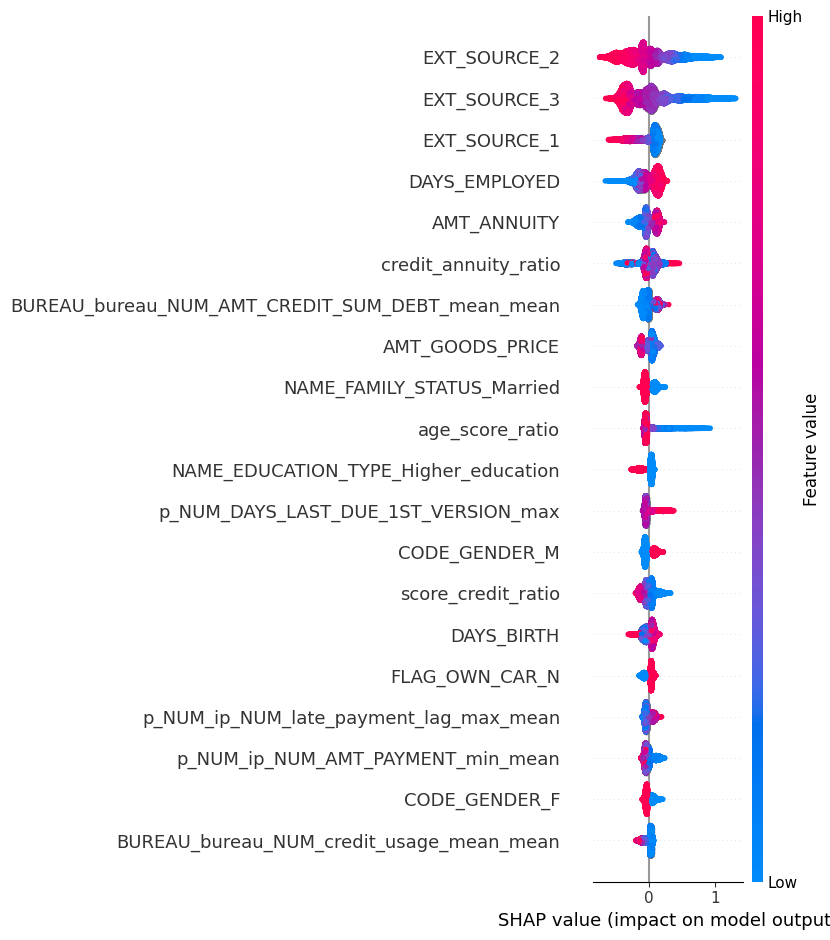

In [ ]:
explainer = shap.TreeExplainer(best_lgbm) 
shap_matrix = explainer(x_final_val, check_additivity=False).values
if isinstance(shap_matrix, list):
    shap_matrix = shap_matrix[1]     
mean_abs_shap = np.abs(shap_matrix).mean(axis=0)

print("SHAP summary plot for best light-gbm:")
fig, ax = plt.subplots()
shap.summary_plot(
    shap_matrix,               
    features=x_final_val,
    feature_names=x_final_val.columns.tolist(),
    max_display=20,             
    show=False
)
plt.show()


SHAP summary plot for best catboost model:


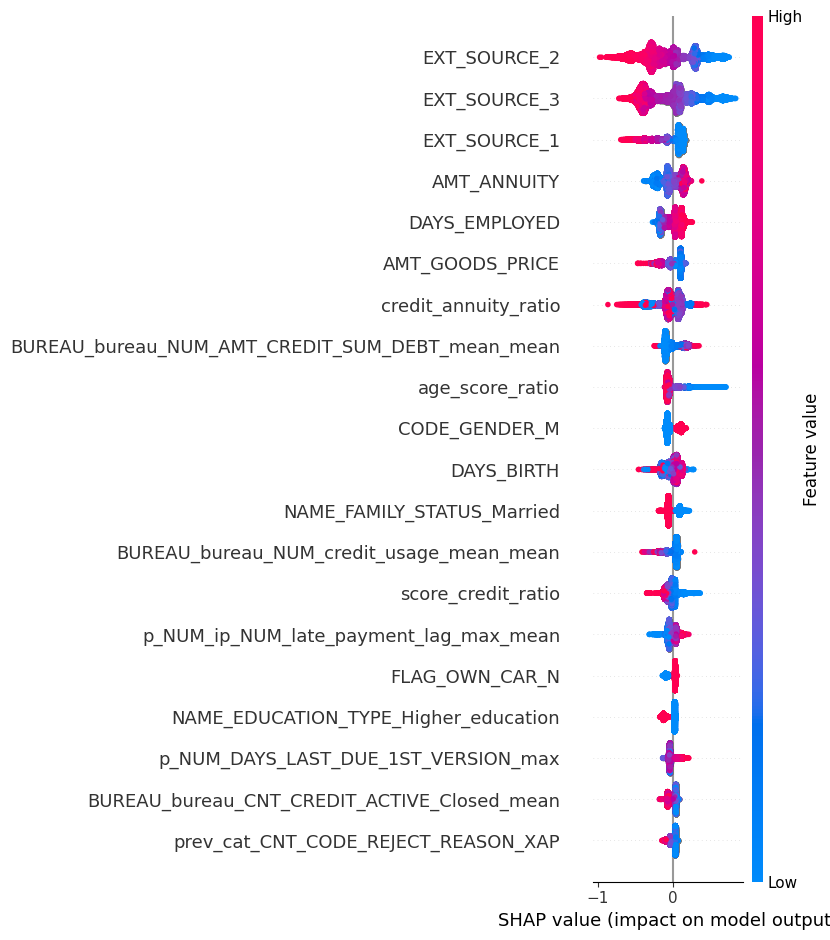

In [ ]:
explainer = shap.TreeExplainer(best_cbc) 
shap_matrix = explainer(x_final_val, check_additivity=False).values
if isinstance(shap_matrix, list):
    shap_matrix = shap_matrix[1]     
mean_abs_shap = np.abs(shap_matrix).mean(axis=0)

print("SHAP summary plot for best catboost model:")
fig, ax = plt.subplots()
shap.summary_plot(
    shap_matrix,               
    features=x_final_val,
    feature_names=x_final_val.columns.tolist(),
    max_display=20,             
    show=False
)
plt.show()


The top 5 features for each model are the same as those found in the initial light-gb shap plot (external credit scores, and time employed). Other important features for both models include financial (the mean amount of debt for the Credit Bureau, AMT_ANNUITY for the current loan, AMT_GOODS_PRICE) and socio-demographic features (age, gender, if a client is married or not), or combinations of these (age_score_ratio)

# Save models

The top models are saved as .pkl files for future use: 

In [ ]:
joblib.dump(best_lgbm, 'best_lgbm_model.pkl')
joblib.dump(voting, 'voting.pkl')
joblib.dump(best_cbc, 'best_catboost_model.pkl');

# Appendix

## Results from data processing changes: 

Aggregating the last 1 previous application: 

| Model                  | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm               | 0.7772 ± 0.0019 | 0.2641 ± 0.0056 | 0.7314 ± 0.0013 | 0.9003 ± 0.0006 | 0.7314 ± 0.0013 | 0.7904 ± 0.0010 | 0.2474 ± 0.0030 |
| hist_gradient_boosting | 0.7756 ± 0.0017 | 0.2610 ± 0.0052 | 0.7338 ± 0.0017 | 0.8998 ± 0.0005 | 0.7338 ± 0.0017 | 0.7921 ± 0.0012 | 0.2465 ± 0.0024 |


This shows a slight improvement.

Aggregating over the last 1 and last 3 previous applications: 

| Model                  | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm               | 0.7778 ± 0.0025 | 0.2645 ± 0.0079 | 0.7325 ± 0.0007 | 0.9001 ± 0.0006 | 0.7325 ± 0.0007 | 0.7912 ± 0.0005 | 0.2470 ± 0.0024 |
| hist_gradient_boosting | 0.7756 ± 0.0016 | 0.2617 ± 0.0053 | 0.7335 ± 0.0022 | 0.8995 ± 0.0004 | 0.7335 ± 0.0022 | 0.7919 ± 0.0016 | 0.2451 ± 0.0026 |


This is also a slight improvement.

Last 1, 3, and 5 applications: 

| Model                  | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm               | 0.7770 ± 0.0019 | 0.2636 ± 0.0076 | 0.7326 ± 0.0019 | 0.9001 ± 0.0005 | 0.7326 ± 0.0019 | 0.7913 ± 0.0014 | 0.2473 ± 0.0030 |
| hist_gradient_boosting | 0.7757 ± 0.0016 | 0.2616 ± 0.0050 | 0.7350 ± 0.0021 | 0.8998 ± 0.0006 | 0.7350 ± 0.0021 | 0.7929 ± 0.0015 | 0.2470 ± 0.0031 |

This is not an improvement.

Adding in 'max' aggregation to all previous applications: 

| Model                  | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm               | 0.7782 ± 0.0023 | 0.2654 ± 0.0067 | 0.7340 ± 0.0018 | 0.9003 ± 0.0006 | 0.7340 ± 0.0018 | 0.7923 ± 0.0013 | 0.2485 ± 0.0029 |
| hist_gradient_boosting | 0.7763 ± 0.0020 | 0.2617 ± 0.0055 | 0.7334 ± 0.0030 | 0.8997 ± 0.0005 | 0.7334 ± 0.0030 | 0.7918 ± 0.0022 | 0.2458 ± 0.0030 |

This is an improvement.

Adding in 'min' aggregation to all previous applications: 

| Model                  | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm               | 0.7779 ± 0.0025 | 0.2653 ± 0.0076 | 0.7333 ± 0.0021 | 0.9001 ± 0.0006 | 0.7333 ± 0.0021 | 0.7918 ± 0.0015 | 0.2476 ± 0.0033 |
| hist_gradient_boosting | 0.7765 ± 0.0019 | 0.2630 ± 0.0060 | 0.7337 ± 0.0032 | 0.9001 ± 0.0004 | 0.7337 ± 0.0032 | 0.7921 ± 0.0023 | 0.2478 ± 0.0030 |

This does not significantly increase auc.

Adding in 'std' aggregation to previous applications: 

| Model                  | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm               | 0.7781 ± 0.0023 | 0.2653 ± 0.0057 | 0.7324 ± 0.0017 | 0.9000 ± 0.0009 | 0.7324 ± 0.0017 | 0.7911 ± 0.0012 | 0.2467 ± 0.0042 |
| hist_gradient_boosting | 0.7760 ± 0.0023 | 0.2630 ± 0.0072 | 0.7346 ± 0.0015 | 0.8998 ± 0.0002 | 0.7346 ± 0.0015 | 0.7927 ± 0.0011 | 0.2467 ± 0.0017 |

This is not an improvement either. 

Now, processing the application table in the same way as in the previous notebook gives: 

| Model                  | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm               | 0.7820 ± 0.0018 | 0.2696 ± 0.0054 | 0.7311 ± 0.0011 | 0.9011 ± 0.0005 | 0.7311 ± 0.0011 | 0.7903 ± 0.0008 | 0.2511 ± 0.0024 |
| hist_gradient_boosting | 0.7794 ± 0.0021 | 0.2662 ± 0.0060 | 0.7330 ± 0.0019 | 0.9005 ± 0.0005 | 0.7330 ± 0.0019 | 0.7915 ± 0.0014 | 0.2490 ± 0.0030 |

This increases auc.

Columns identified in the capstone_table_eda notebook with high cardinality are also grouped to see how this influences model output. These columns include: 
- CREDIT_TYPE from the bureau table,
- NAME_CONTRACT_STATUS from the POS_CASH_balance table,
- NAME_CASH_LOAN_PURPOSE from the previous_application table, and 
- NAME_GOODS_CATEGORY from the previous_application table. This results in: 

| Model                  | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm               | 0.7818 ± 0.0018 | 0.2691 ± 0.0061 | 0.7313 ± 0.0015 | 0.9010 ± 0.0008 | 0.7313 ± 0.0015 | 0.7904 ± 0.0011 | 0.2508 ± 0.0040 |
| hist_gradient_boosting | 0.7796 ± 0.0021 | 0.2662 ± 0.0062 | 0.7331 ± 0.0014 | 0.9009 ± 0.0006 | 0.7331 ± 0.0014 | 0.7917 ± 0.0010 | 0.2510 ± 0.0033 |

This does not significantly influence the model.

## Results for feature engineering with other tables: 

It is possible that feature engineering with all tables before aggregation could increase model auc. Some features are selected to test that have to to with a client's previous loan behavior, such as late payment behavior. As no domain expert is available for questioning, chatgpt has helped with providing some feature engineering suggestions. Lightgbm model alone is used to evaluate each feature, as its performance has been consistently better than hist_gradient_boosting's performance. 

Feature added: payment_lag from installments_payments table (DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT)

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7825 ± 0.0027 | 0.2704 ± 0.0073 | 0.7321 ± 0.0016 | 0.9014 ± 0.0007 | 0.7321 ± 0.0016 | 0.7910 ± 0.0012 | 0.2528 ± 0.0037 |

This is an improvement. 

Now, adding the ratio of AMT_PAYMENT/AMT_INSTALMENT from the installments_payments table: 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7824 ± 0.0027 | 0.2697 ± 0.0065 | 0.7330 ± 0.0017 | 0.9013 ± 0.0005 | 0.7330 ± 0.0017 | 0.7916 ± 0.0013 | 0.2529 ± 0.0026 |

This is not an improvement. 

Next, the difference between AMT_INSTALMENT and AMT_PAYMENT from the installments_payments table is added:

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7820 ± 0.0026 | 0.2704 ± 0.0068 | 0.7329 ± 0.0007 | 0.9012 ± 0.0005 | 0.7329 ± 0.0007 | 0.7916 ± 0.0005 | 0.2525 ± 0.0022 |

This gives essentially the same result as the previous difference and will not be added.

Feature added: AMT_DRAWINGS_ATM_CURRENT/AMT_TOTAL_RECEIVABLE from credit_card_balance, as it shows a measure of credit to payment ratio. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7827 ± 0.0023 | 0.2699 ± 0.0069 | 0.7332 ± 0.0014 | 0.9011 ± 0.0006 | 0.7332 ± 0.0014 | 0.7918 ± 0.0010 | 0.2520 ± 0.0031 |

This gives a higher auc and will be added.

Feature added: difference between AMT_CREDIT and AMT_APPLICATION from previous_application.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7825 ± 0.0022 | 0.2695 ± 0.0054 | 0.7329 ± 0.0019 | 0.9013 ± 0.0004 | 0.7329 ± 0.0019 | 0.7916 ± 0.0013 | 0.2527 ± 0.0020 |

This is not an improvement.



Feature added: ratio of AMT_ANNUITY/AMT_CREDIT from previous_application. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7827 ± 0.0024 | 0.2695 ± 0.0068 | 0.7327 ± 0.0021 | 0.9013 ± 0.0007 | 0.7327 ± 0.0021 | 0.7914 ± 0.0015 | 0.2527 ± 0.0038 |

This is essentially the same as the previous top auc and will not be kept.

Feature added: ratio between AMT_ANNUITY/AMT_DOWN_PAYMENT from previous_application. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7823 ± 0.0029 | 0.2693 ± 0.0065 | 0.7317 ± 0.0011 | 0.9012 ± 0.0006 | 0.7317 ± 0.0011 | 0.7907 ± 0.0008 | 0.2516 ± 0.0027 |

This does not increase auc.

Feature added: difference between total drawings and AMT_PAYMENT_TOTAL_CURRENT from credit_card_balance table. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7824 ± 0.0024 | 0.2695 ± 0.0065 | 0.7326 ± 0.0015 | 0.9011 ± 0.0006 | 0.7326 ± 0.0015 | 0.7913 ± 0.0011 | 0.2515 ± 0.0030 |

This does not quite increase auc. 

Feature added: difference between total drawings and CNT_PAYMENT_TOTAL_CURRENT from the credit_card_balance table.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7825 ± 0.0024 | 0.2699 ± 0.0059 | 0.7329 ± 0.0010 | 0.9010 ± 0.0006 | 0.7329 ± 0.0010 | 0.7915 ± 0.0007 | 0.2514 ± 0.0026 |

This decreases auc. 

Feature added: difference between AMT_PAYMENT_CURRENT and AMT_INST_MIN_REGULARITY from the credit_card_balance table.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7824 ± 0.0022 | 0.2694 ± 0.0064 | 0.7330 ± 0.0018 | 0.9013 ± 0.0007 | 0.7330 ± 0.0018 | 0.7917 ± 0.0013 | 0.2530 ± 0.0037 |

This does not increase auc.

Adding feature: difference between credit limit and balance from the credit_card_balance table. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7824 ± 0.0022 | 0.2703 ± 0.0067 | 0.7339 ± 0.0016 | 0.9011 ± 0.0005 | 0.7339 ± 0.0016 | 0.7923 ± 0.0011 | 0.2523 ± 0.0030 |

This also does not increase auc. 

Adding feature: AMT_CREDIT_SUM_DEBT/AMT_CREDIT_SUM_LIMIT' from bureau table. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7829 ± 0.0027 | 0.2715 ± 0.0061 | 0.7330 ± 0.0016 | 0.9014 ± 0.0005 | 0.7330 ± 0.0016 | 0.7916 ± 0.0011 | 0.2532 ± 0.0025 |

This is an improvement and will be kept.

Feature added: AMT_APPLICATION/AMT_CREDIT from previous application. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7829 ± 0.0026 | 0.2705 ± 0.0063 | 0.7332 ± 0.0015 | 0.9013 ± 0.0008 | 0.7332 ± 0.0015 | 0.7918 ± 0.0011 | 0.2527 ± 0.0043 |

This gives the same score as the previous highest auc, and will not be kept. 

New feature: CNT_INSTALMENT_FUTURE/CNT_INSTALMENT from POS_CASH_balance table. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7830 ± 0.0021 | 0.2709 ± 0.0057 | 0.7337 ± 0.0014 | 0.9014 ± 0.0006 | 0.7337 ± 0.0014 | 0.7921 ± 0.0010 | 0.2535 ± 0.0030 |

This is a slight improvement and is kept. 

New feature: AMT_CREDIT_SUM_DEBT/AMT_CREDIT_SUM_LIMIT' from bureau table.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7832 ± 0.0019 | 0.2708 ± 0.0060 | 0.7337 ± 0.0017 | 0.9014 ± 0.0005 | 0.7337 ± 0.0017 | 0.7922 ± 0.0012 | 0.2536 ± 0.0026 |

This feature did help slightly and will be kept. 


New feature: DAYS_FIRST_DRAWING/DAYS_FIRST_DUE from previous_application table.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7834 ± 0.0022 | 0.2709 ± 0.0068 | 0.7344 ± 0.0020 | 0.9015 ± 0.0009 | 0.7344 ± 0.0020 | 0.7927 ± 0.0015 | 0.2545 ± 0.0049 |

This feature also slightly increases auc and is kept.

New feature: DAYS_FIRST_DUE-DAYS_LAST_DUE_1ST_VERSION from previous_application table.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7827 ± 0.0021 | 0.2706 ± 0.0055 | 0.7334 ± 0.0018 | 0.9013 ± 0.0007 | 0.7334 ± 0.0018 | 0.7919 ± 0.0013 | 0.2529 ± 0.0039 |

This does not increase auc.

Feature added: active credit flag from bureau table. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7834 ± 0.0022 | 0.2709 ± 0.0068 | 0.7344 ± 0.0020 | 0.9015 ± 0.0009 | 0.7344 ± 0.0020 | 0.7927 ± 0.0015 | 0.2545 ± 0.0049 |

Adding this feature does not change the model whatsoever.

New feature: DAYS_CREDIT_ENDDATE - DAYS_CREDIT from bureau table. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7832 ± 0.0019 | 0.2704 ± 0.0064 | 0.7333 ± 0.0018 | 0.9015 ± 0.0006 | 0.7333 ± 0.0018 | 0.7919 ± 0.0013 | 0.2537 ± 0.0031 |

This does not increase model auc and is not added.

New feature: late payment flag from installments_payments table.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7834 ± 0.0022 | 0.2709 ± 0.0068 | 0.7344 ± 0.0020 | 0.9015 ± 0.0009 | 0.7344 ± 0.0020 | 0.7927 ± 0.0015 | 0.2545 ± 0.0049 |

This does not increase model auc and is not added.

New feature: AMT_BALANCE/AMT_CREDIT_LIMIT_ACTUAL from credit_card_balance table.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7833 ± 0.0023 | 0.2715 ± 0.0062 | 0.7339 ± 0.0021 | 0.9015 ± 0.0006 | 0.7339 ± 0.0021 | 0.7923 ± 0.0015 | 0.2540 ± 0.0035 |

This does not increase model auc and is not added.

New feature: tracking if any credit_card_balance table payments are missed (if AMT_PAYMENT_TOTAL_CURRENT is less than AMT_INST_MIN_REGULARITY). 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7834 ± 0.0022 | 0.2709 ± 0.0068 | 0.7344 ± 0.0020 | 0.9015 ± 0.0009 | 0.7344 ± 0.0020 | 0.7927 ± 0.0015 | 0.2545 ± 0.0049 |

This also does not increase model auc.


New feature: if a contract has been completed from the POS_CAHS_balance table.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7834 ± 0.0022 | 0.2709 ± 0.0068 | 0.7344 ± 0.0020 | 0.9015 ± 0.0009 | 0.7344 ± 0.0020 | 0.7927 ± 0.0015 | 0.2545 ± 0.0049 |

This does not increase model auc. 

New feature: The maximum days past due from the POS_CASH_balance table.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7833 ± 0.0022 | 0.2707 ± 0.0057 | 0.7341 ± 0.0021 | 0.9015 ± 0.0008 | 0.7341 ± 0.0021 | 0.7924 ± 0.0016 | 0.2542 ± 0.0045 |

This decreases model auc.

New feature: DAYS_DECISION-DAYS_FIRST_DRAWING from previous_application table. 

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7830 ± 0.0018 | 0.2715 ± 0.0069 | 0.7333 ± 0.0021 | 0.9014 ± 0.0005 | 0.7333 ± 0.0021 | 0.7919 ± 0.0015 | 0.2535 ± 0.0028 |

This also decreases model auc.


New feature: AMT_CREDIT/AMT_APPLICATION from previous_application table.

| Model    | AUC             | PR AUC          | RECALL          | PRECISION       | ACCURACY        | WEIGHTED F1     | MCC             |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| lightgbm | 0.7833 ± 0.0028 | 0.2709 ± 0.0049 | 0.7334 ± 0.0025 | 0.9015 ± 0.0006 | 0.7334 ± 0.0025 | 0.7920 ± 0.0018 | 0.2537 ± 0.0036 |

This decreases model auc.